In [301]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np
from IPython.display import display, clear_output
import seaborn as sns

In [302]:
# Give all the plots a seaborn style
sns.set(style="whitegrid")

# Give all the plots LaTex font and text    
rc('text', usetex=True)
rc('font', family='serif')

# Preprocess Data

In [303]:
# Read data
Gold = pd.read_excel("/Users/koensmallegange/Desktop/Research-Practicum/Data/FUT_Option.xlsx")

# Convert to datetime
Gold['date'] = pd.to_datetime(Gold['date'])
Gold['futures_expiration_date'] = pd.to_datetime(Gold['futures_expiration_date'])
Gold['options_expiration_date'] = pd.to_datetime(Gold['options_expiration_date'], errors='coerce')

Gold = Gold[Gold['options_expiration_date'] >= '2019-10-18']
Gold['TTM'] = (Gold['options_expiration_date'] - Gold['date']).dt.days / 365.25

# Rescale
Gold['futures_close'] = Gold['futures_close']/1000000
Gold['strike'] = Gold['strike']/1000000
Gold['bid'] = Gold['bid']/1000000
Gold['ask'] = Gold['ask']/1000000
Gold['settlement'] = Gold['settlement']/1000000
Gold['vega'] = Gold['vega']/1000000

# Isolate call and put
Gold_call = Gold[Gold['call_put'] == 'C'].copy()
Gold_put = Gold[Gold['call_put'] == 'P'].copy()

# Sort by date
Gold_call.sort_values('date', inplace=True)
Gold_put.sort_values('date', inplace=True)

# Drop non-numeric columns if there are any
data = Gold_call.select_dtypes(include=[np.number])
data = data.drop(['delta', 'vega', 'gamma', 'theta'], axis=1)

# Filter out rows with IV > 1000
mask = data['iv'] > 1000
data = data[~mask]

# Normalize the data
scaler = MinMaxScaler(feature_range=(-1, 1))
data_scaled = scaler.fit_transform(data)


In [329]:
data

futures_close  strike  bid  ask  settlement        iv  iv_interpolated  \
0        1483.500000  1275.0  0.0  0.0  208.600006  0.651953         0.651953   
7306     1523.199951  1240.0  0.0  0.0  293.299988  0.155148         0.155148   
7304     1523.199951  1230.0  0.0  0.0  302.200012  0.157257         0.157257   
7302     1523.199951  1225.0  0.0  0.0  306.600006  0.158140         0.158140   
7300     1523.199951  1220.0  0.0  0.0  311.100006  0.159270         0.159270   
...              ...     ...  ...  ...         ...       ...              ...   
3810     1504.900024  1095.0  0.0  0.0  409.899994  0.236580         0.236580   
3808     1504.900024  1090.0  0.0  0.0  414.899994  0.239999         0.239999   
3806     1504.900024  1085.0  0.0  0.0  419.899994  0.243437         0.243437   
3842     1504.900024  1175.0  0.0  0.0  329.899994  0.183995         0.183995   
10776    1595.900024  2150.0  0.0  0.0  143.000000  0.214597         0.214597   

       volume  open_interest       TTM  
0           0              0  0.008214  
7306        0              0  1.533196  
7304        0              0  1.533196  
7302        0              0  1.533196  
7300        0              0  1.533196  
...       ...            ...       ...  
3810        0              0  0.695414  
3808        0              0  0.695414  
3806        0              0  0.695414  
3842        0              0  0.695414  
10776       0              0  5.615332  

[5211 rows x 10 columns]

# Build the Market Data Simulator

### Parameters

In [343]:

# Set hyperparameters
BATCH_SIZE = 128
NOISE_DIM = 75
BUFFER_SIZE = 5389 
EPOCHS = 1000

# Define the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices(data_scaled).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


### Define the GAN's networks

In [313]:

def make_generator_model():
    '''Generates a network that generates synthetic data'''
    model = tf.keras.Sequential([
        layers.Dense(BATCH_SIZE, activation='relu', input_shape=(NOISE_DIM,)),
        layers.Dense(data_scaled.shape[1], activation='tanh')
    ])
    return model

def make_discriminator_model():
    '''Generates a network that discriminates real from synthetic data'''
    model = tf.keras.Sequential([
        layers.Dense(BATCH_SIZE, activation='relu', input_shape=(data_scaled.shape[1],)),
        layers.Dense(1, activation='sigmoid')
    ])
    return model



In [314]:
# Instantiate the models
generator = make_generator_model()
discriminator = make_discriminator_model()

# Define the loss and optimizers
cross_entropy = tf.keras.losses.BinaryCrossentropy()
generator_optimizer = tf.keras.optimizers.Adam()
discriminator_optimizer = tf.keras.optimizers.Adam()

### Train the model

In [315]:
# Define the training loop
@tf.function
def train_step(real_data):
    # Sample noise from a normal distribution
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    # Train the discriminator
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_data = generator(noise, training=True)
        
        # Discriminate real from fake data
        real_output = discriminator(real_data, training=True)
        fake_output = discriminator(generated_data, training=True)
        
        # Calculate the losses
        gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
        disc_loss = (cross_entropy(tf.ones_like(real_output), real_output) +
                     cross_entropy(tf.zeros_like(fake_output), fake_output))
        
    # Calculate the gradients
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    # Update the weights
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

# Training loop
def train(dataset, epochs):
    '''Trains the GAN'''
    for epoch in range(epochs):
        for data_batch in dataset:
            train_step(data_batch)

        # Display progress
        clear_output(wait=True)
        display(f'Epoch {epoch + 1}/{epochs} completed')
        
# Initialize the training
train(train_dataset, epochs=EPOCHS)

'Epoch 1000/1000 completed'

### Hyperparameters meaning

BATCH_SIZE (256): Number of training examples used in one iteration of model training. In a dataset, data is usually divided into batches, and each batch is fed into the network one at a time. A batch size of 256 means that 256 data points from the dataset are used for each training step.

NOISE_DIM (100): Refers to the dimensionality of the random noise vector that is input into the generator network. A noise dimension of 100 means that the generator takes in a random vector of size 100 to generate data.

BUFFER_SIZE (60000): Defines the size of the buffer used to shuffle the dataset. A larger buffer size ensures better randomization of data. In TensorFlow, for example, Dataset.shuffle(buffer_size) randomly shuffles the elements of the dataset. A buffer size of 60000 in this context would mean the dataset is shuffled using a buffer that can hold 60000 elements.

# Analyze the Synthethic Data

### Paramaters



In [344]:
accuracy = 5
step_daily = 0.00273785078
step_weekly = 0.14285714285
random_samples = 50000



### Get the synthetic data

In [345]:
# Generate random noise
random_noise = tf.random.normal([random_samples, NOISE_DIM])

# Use the generator to create option prices
simulated_data = generator(random_noise, training=False)

# Rescale the data
simulated_data_rescaled = scaler.inverse_transform(simulated_data)

# Convert the generated data to pandas df
simulated_data_df = pd.DataFrame(simulated_data_rescaled, columns=data.columns)

In [318]:
simulated_data_df.tail(50)

futures_close       strike         bid         ask  settlement  \
49950    1542.710221  1386.800289  746.296229  746.991384  630.784647   
49951    1536.683214  1497.507697  746.299988  747.000000  625.411297   
49952    1539.555238  1619.949408  746.299988  746.999911  699.070647   
49953    1560.228615  1426.548284  746.299944  747.000000  725.794299   
49954    1504.681538  1340.091050  731.553892  726.403934  400.232236   
49955    1518.874042  1304.647142  734.909173  539.477550  522.505615   
49956    1504.675763  1284.072712  745.204217  745.674100  555.006843   
49957    1551.784399  1568.050952  746.299276  746.999176  749.996869   
49958    1565.989761  1354.780453  746.299966  746.999978  788.795423   
49959    1542.672501  1577.829611  746.296585  746.994434  692.987027   
49960    1557.815823  1602.557214  746.299966  746.999978  707.950479   
49961    1539.783081  1491.423321  746.299966  746.999978  705.476532   
49962    1549.961811  1402.440223  746.276323  746.996505  669.830971   
49963    1517.921609  1224.957997  746.299766  746.999822  731.064982   
49964    1523.335139  1407.527551  746.298720  746.999844  562.480709   
49965    1514.895086  1351.639131  746.299966  746.999978  727.113795   
49966    1554.984497  1424.330544  746.299966  746.999978  745.551645   
49967    1505.011069  1422.541600  746.299988  746.999978  661.379243   
49968    1546.091929  1540.772802  746.299988  746.999978  731.627192   
49969    1523.424412  1478.959721  746.299032  746.999777  507.237014   
49970    1555.653080  1416.739187  746.296452  746.992653  710.023492   
49971    1540.863589  1465.786839  746.299677  746.999599  662.311401   
49972    1565.242111  1543.953021  746.299988  747.000000  739.339143   
49973    1527.849933  1279.087469  730.806445  718.261151  654.259939   
49974    1516.870090  1286.432859  746.288356  746.951134  606.562542   
49975    1529.915486  1583.107586  678.915910  548.824992  453.780568   
49976    1534.603056  1675.118907  746.293760  746.990739  630.879347   
49977    1566.008491  1471.279752  746.299988  746.999978  742.637906   
49978    1536.657610  1384.313568  746.015475  746.560141  670.635916   
49979    1526.887502  1260.044214  746.299966  746.999978  713.911229   
49980    1502.667418  1227.447176  746.299944  746.999933  684.873188   
49981    1550.663850  1501.686588  746.298854  746.999889  606.537829   
49982    1540.189740  1481.474274  746.290180  746.999399  529.036792   
49983    1526.893965  1332.870561  739.903563  744.694936  438.627047   
49984    1564.418593  1416.842157  746.278325  746.991451  684.835785   
49985    1554.607001  1461.866504  746.299921  747.000000  737.871754   
49986    1551.706172  1795.443143  746.299966  746.999978  739.857867   
49987    1504.806247  1442.945987  746.299187  746.999933  516.761887   
49988    1516.231294  1571.064423  746.299966  746.999978  645.184673   
49989    1567.856753  1636.000238  746.299899  747.000000  645.698984   
49990    1523.248328  1535.272069  746.298498  746.998776  610.580114   
49991    1529.502799  1364.148462  479.518214   82.347686  581.520307   
49992    1540.291434  1436.212122  746.296741  746.998241  660.154351   
49993    1517.645508  1252.887356  746.298565  746.997996  668.403370   
49994    1511.982829  1617.071116  746.262867  746.957412  406.165086   
49995    1509.374344  1281.100941  746.298476  746.995347  683.940195   
49996    1557.690960  1369.077253  746.299988  747.000000  779.427447   
49997    1503.016833  1475.911927  746.286109  746.998264  506.848448   
49998    1548.549076  1291.871682  746.299944  747.000000  740.700526   
49999    1570.989469  1526.221626  746.299966  746.999978  751.949801   

             iv  iv_interpolated       volume  open_interest       TTM  
49950  0.967669         0.825233  3574.999893   30814.000000  2.766129  
49951  0.947062         0.677498  3574.999893   30813.999082  3.067153  
49952  0.984573         0.775436  3574.999893   30813.999082  3.

### Discretize the Time to Maturity (TTM)

Replaces each TTM value in the generated data with the nearest TTM value from the original dataset. 

In [346]:
from scipy.spatial import cKDTree

# Quantize TTM values to the nearest multiple of the step
# simulated_data_df['TTM'] = (np.round(simulated_data_df['TTM'] / step_daily) * step_daily).astype(float)

# Convert the original TTM values into a KDTree for efficient nearest neighbor search
# original_TTM_tree = cKDTree(np.array(data['TTM']).reshape(-1, 1))

# Replace generated TTM values with nearest original TTM values
# generated_TTM_values = simulated_data_df['TTM']
# nearest_indices = original_TTM_tree.query(generated_TTM_values.values.reshape(-1, 1))[1]
# simulated_data_df['TTM'] = np.array(data['TTM'])[nearest_indices]

# Convert the original future_close values into a KDTree for efficient nearest neighbor search
# original_TTM_tree = cKDTree(np.array(data['futures_close']).reshape(-1, 1))

# Replace generated future_close values with nearest original future_close values
# generated_TTM_values = simulated_data_df['futures_close']
# nearest_indices = original_TTM_tree.query(generated_TTM_values.values.reshape(-1, 1))[1]
# simulated_data_df['futures_close'] = np.array(data['futures_close'])[nearest_indices]

### Round the prices 

In [347]:
simulated_data_df['strike'] = (simulated_data_df['strike'] / accuracy).round() * accuracy
simulated_data_df['Moneyness'] = simulated_data_df['strike']/simulated_data_df['futures_close']

# print amount of rows in simulated data
print('Amount of rows in simulated data: ' + str(len(simulated_data_df)))

Amount of rows in simulated data: 50000


In [348]:
data.describe()

futures_close       strike          bid          ask    settlement  \
count    5211.000000  5211.000000  5211.000000  5211.000000  5.211000e+03   
mean     1520.018618  1457.359432    11.892957    12.010651  1.965683e+02   
std        30.487909   301.393442    53.712692    53.870262  1.700266e+02   
min      1483.500000   700.000000     0.000000     0.000000  1.000000e-07   
25%      1495.400024  1235.000000     0.000000     0.000000  5.385000e+01   
50%      1513.099976  1460.000000     0.000000     0.000000  1.531000e+02   
75%      1533.599976  1675.000000     0.000000     0.000000  3.034000e+02   
max      1595.900024  4000.000000   746.299988   747.000000  8.004000e+02   

                iv  iv_interpolated       volume  open_interest          TTM  
count  5211.000000      5211.000000  5211.000000    5211.000000  5211.000000  
mean      0.203285         0.203285     7.148532     243.924966     1.575003  
std       0.096550         0.096550    90.233165    1357.393965     1.522932  
min       0.117828         0.117828     0.000000       0.000000     0.008214  
25%       0.152365         0.152365     0.000000       0.000000     0.446270  
50%       0.174411         0.174411     0.000000       0.000000     1.034908  
75%       0.208882         0.208882     0.000000       0.000000     2.108145  
max       0.996030         0.996030  3575.000000   30814.000000     5.615332

In [349]:
simulated_data_df.describe()

futures_close        strike           bid           ask    settlement  \
count   50000.000000  50000.000000  50000.000000  50000.000000  50000.000000   
mean     1533.486166   1431.964200    741.598735    738.732216    641.160875   
std        20.061886    114.832172     40.758314     59.004217    105.223380   
min      1484.701088   1015.000000      0.000000      0.000000     24.797578   
25%      1518.020589   1355.000000    746.269111    746.972105    582.351358   
50%      1531.476619   1430.000000    746.299254    746.999622    663.444706   
75%      1547.544688   1510.000000    746.299966    746.999978    722.471682   
max      1594.074694   2075.000000    746.300032    747.000045    798.210008   

                 iv  iv_interpolated        volume  open_interest  \
count  50000.000000     50000.000000  50000.000000   50000.000000   
mean       0.911018         0.667825   3562.619063   30349.446868   
std        0.085131         0.174289    172.069428    3121.435148   
min        0.142202         0.120651      0.000000       0.000000   
25%        0.879446         0.540592   3574.999893   30813.893474   
50%        0.939135         0.683768   3574.999893   30813.999082   
75%        0.971289         0.808686   3574.999893   30813.999082   
max        0.995962         0.992479   3575.000213   30814.001837   

                TTM     Moneyness  
count  50000.000000  50000.000000  
mean       2.520708      0.933750  
std        0.859661      0.073236  
min        0.077384      0.670226  
25%        1.875135      0.883327  
50%        2.441819      0.932230  
75%        3.096639      0.982226  
max        5.437368      1.319784

### Plot features

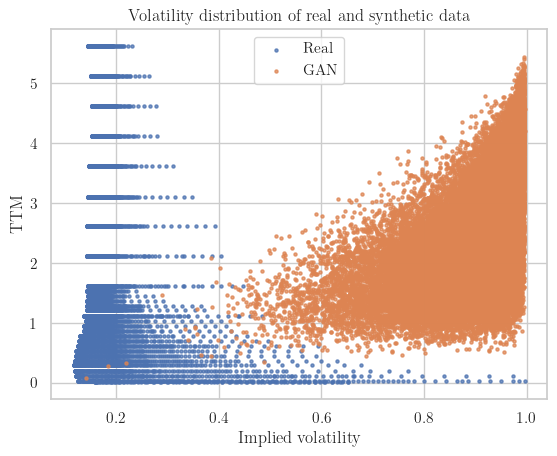

In [353]:
plt.scatter(data['iv'], data['TTM'], alpha = 0.75, s=5, label = "Real")
plt.scatter(simulated_data_df['iv'], simulated_data_df['TTM'], alpha = 0.75, s=5, label = "GAN")
plt.title("Volatility distribution of real and synthetic data")
plt.xlabel("Implied volatility")
plt.ylabel("TTM")
plt.legend()

In [351]:
simulated_data_df

futures_close  strike         bid         ask  settlement        iv  \
0        1571.193200  1380.0  746.299810  746.999911  767.010935  0.955484   
1        1496.718125  1085.0    0.786503    0.000623  426.228287  0.443476   
2        1535.121294  1545.0  746.298654  746.999911  455.573872  0.869917   
3        1505.887496  1465.0  746.299966  746.999978  733.851462  0.986530   
4        1551.632962  1305.0  746.299855  746.999911  758.397096  0.951491   
...              ...     ...         ...         ...         ...       ...   
49995    1509.374344  1280.0  746.298476  746.995347  683.940195  0.939761   
49996    1557.690960  1370.0  746.299988  747.000000  779.427447  0.980745   
49997    1503.016833  1475.0  746.286109  746.998264  506.848448  0.746214   
49998    1548.549076  1290.0  746.299944  747.000000  740.700526  0.972969   
49999    1570.989469  1525.0  746.299966  746.999978  751.949801  0.982078   

       iv_interpolated       volume  open_interest       TTM  Moneyness  
0             0.841336  3574.999893   30813.999082  3.996926   0.878313  
1             0.199826     0.000000       0.000000  0.664663   0.724919  
2             0.406457  3574.999893   30813.999082  2.852539   1.006435  
3             0.765355  3574.999893   30813.999082  2.341472   0.972848  
4             0.765687  3574.999893   30813.999082  3.321580   0.841049  
...                ...          ...            ...       ...        ...  
49995         0.739053  3574.999787   30813.848476  1.375671   0.848033  
49996         0.879585  3574.999893   30813.999082  3.189377   0.879507  
49997         0.319991  3574.999893   30813.986225  1.472464   0.981360  
49998         0.919232  3574.999893   30814.000000  2.697628   0.833038  
49999         0.819912  3574.999893   30813.999082  4.412529   0.970726  

[50000 rows x 11 columns]

In [336]:
simulated_data_df['TTM'].value_counts()

TTM
2.286105    3242
2.143737    3215
2.001369    3100
2.428474    3076
2.570842    3030
1.856263    2909
2.713210    2770
2.858316    2612
1.713895    2607
3.000684    2454
1.571526    2371
3.143053    2199
1.429158    1946
3.285421    1913
3.427789    1736
1.286790    1514
3.570157    1442
3.715264    1234
3.857632    1061
1.141684    1030
4.000000     840
4.142368     709
0.999316     660
4.284736     555
4.429843     431
0.856947     335
4.572211     289
4.714579     225
0.714579     158
4.856947     147
4.999316      88
0.572211      42
5.141684      35
5.286790      13
0.429843       6
0.284736       3
5.429158       2
0.142368       1
Name: count, dtype: int64

In [337]:
unique_ttms = simulated_data_df['TTM'].unique()
target_ttms = np.arange(0, max(unique_ttms).round(), 0.5)
closest_ttms = np.array([unique_ttms[np.argmin(np.abs(unique_ttms - target))] for target in target_ttms])

/var/folders/8b/t8hf_6ks3xz0jvr9wqs_8q6h0000gn/T/ipykernel_62685/997312057.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


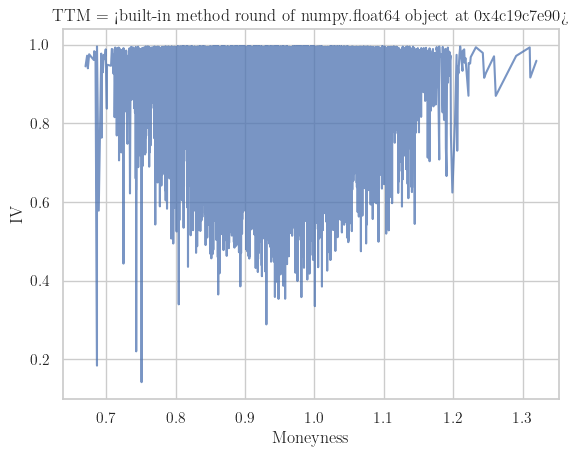

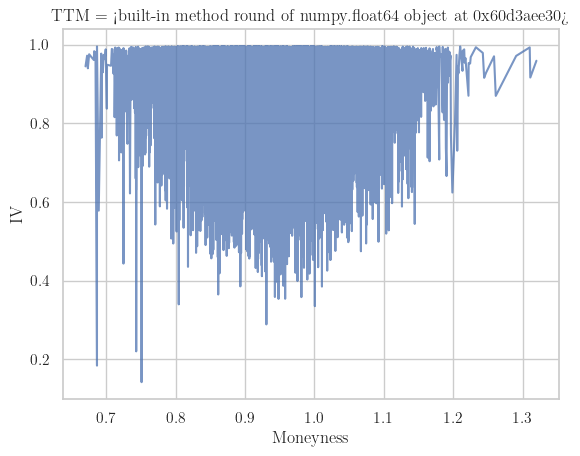

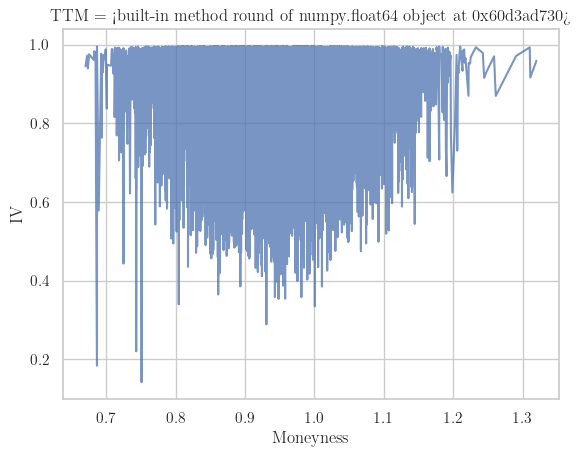

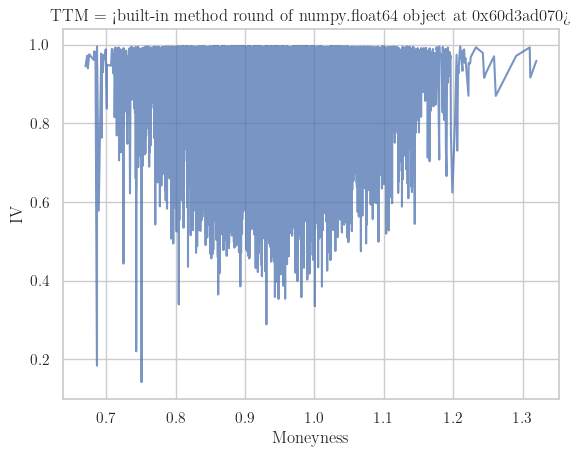

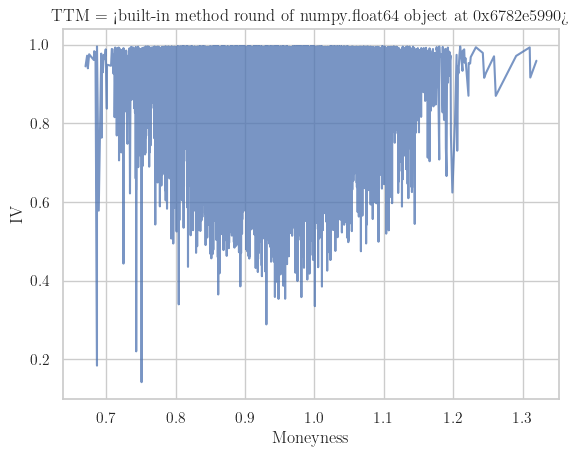

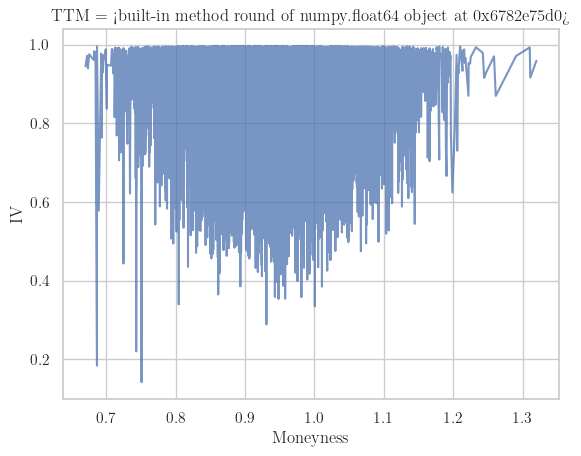

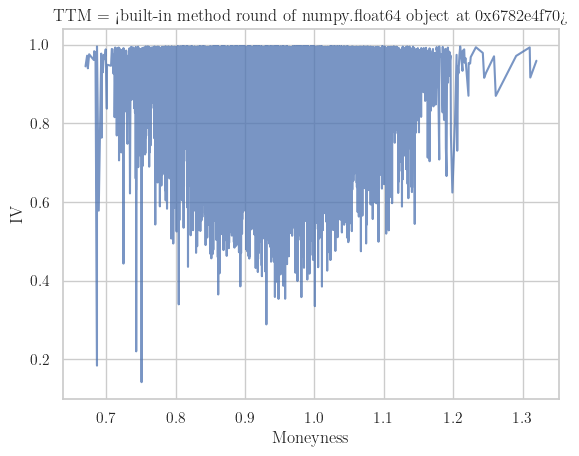

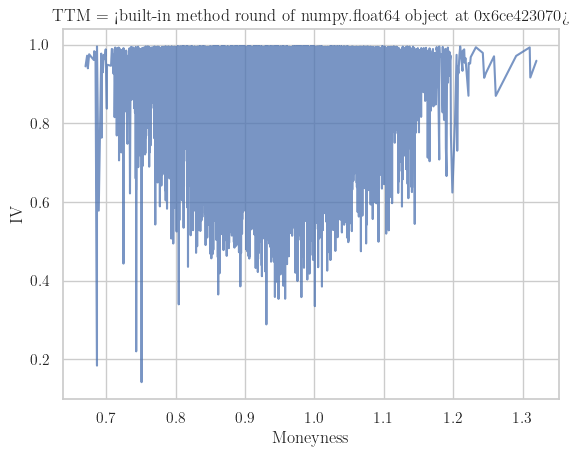

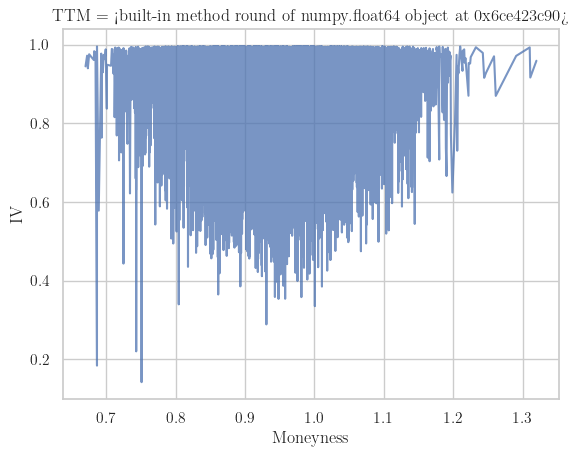

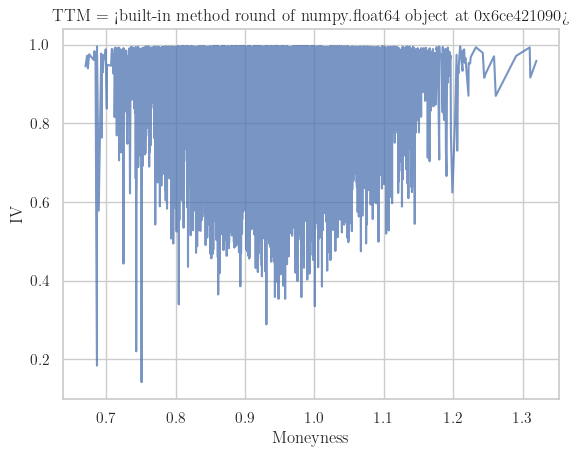

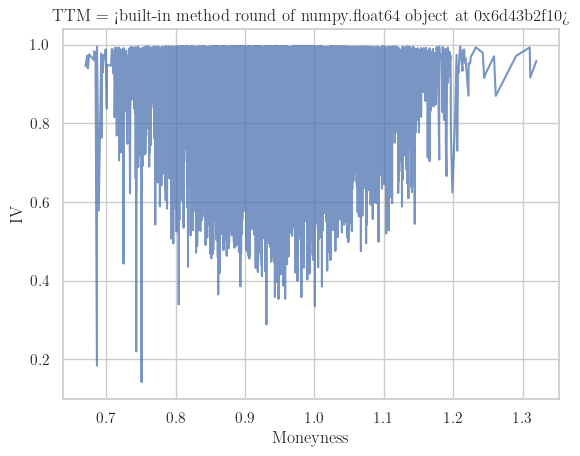

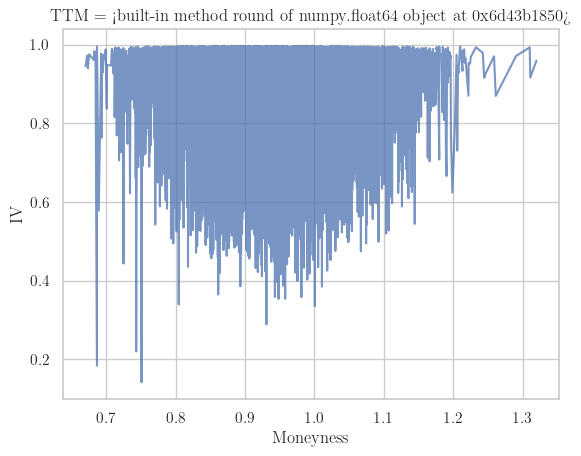

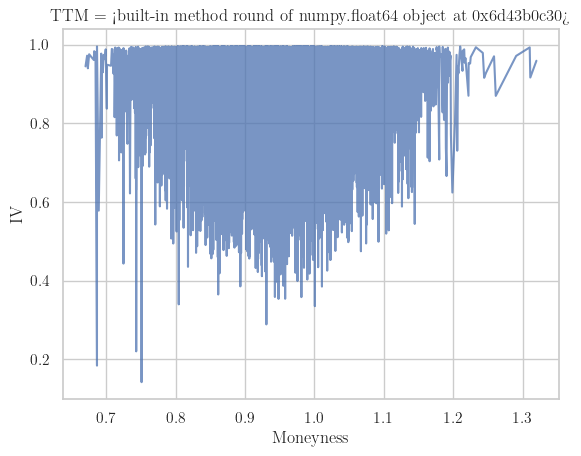

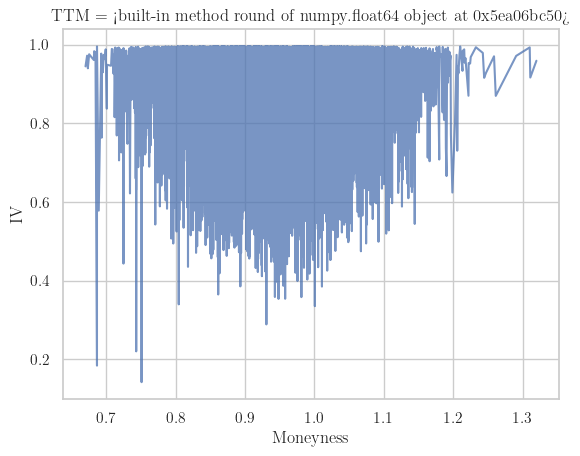

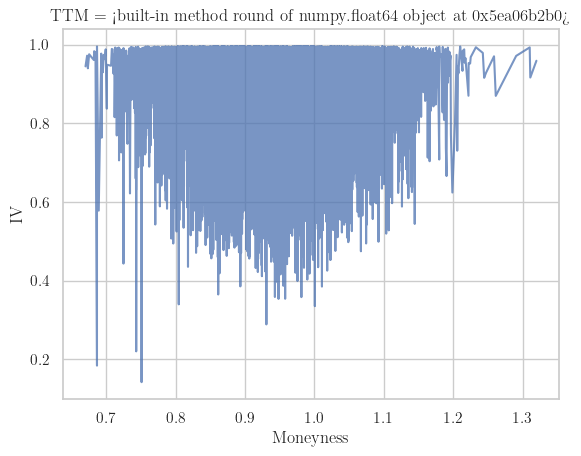

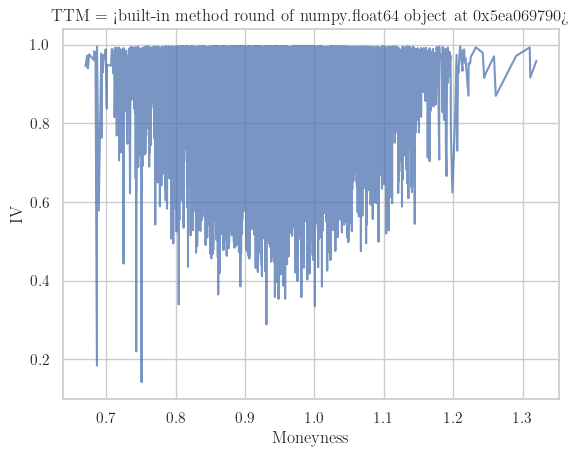

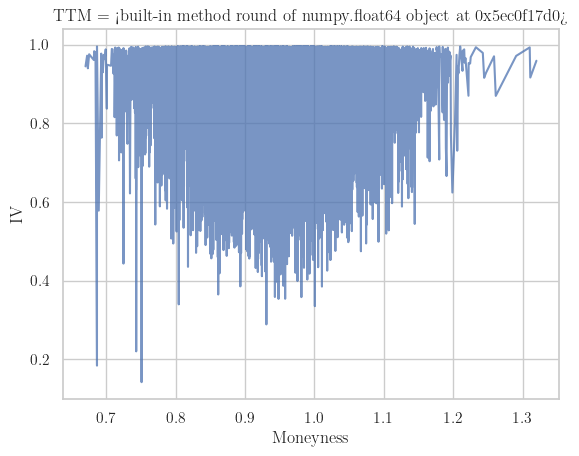

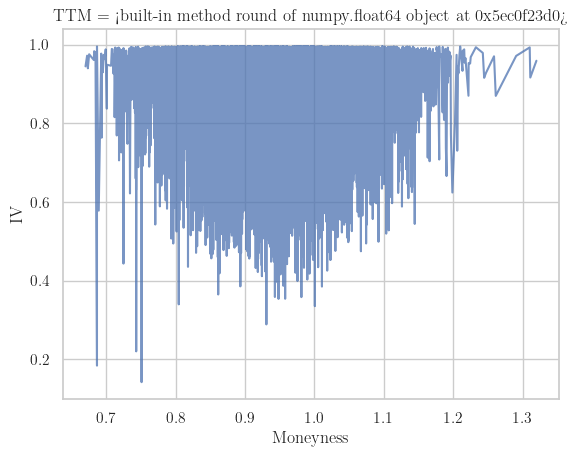

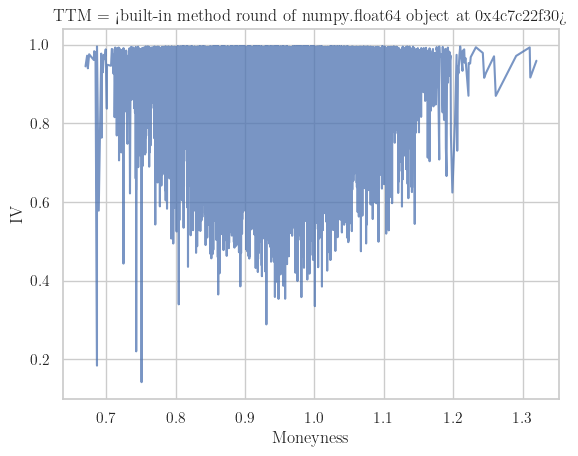

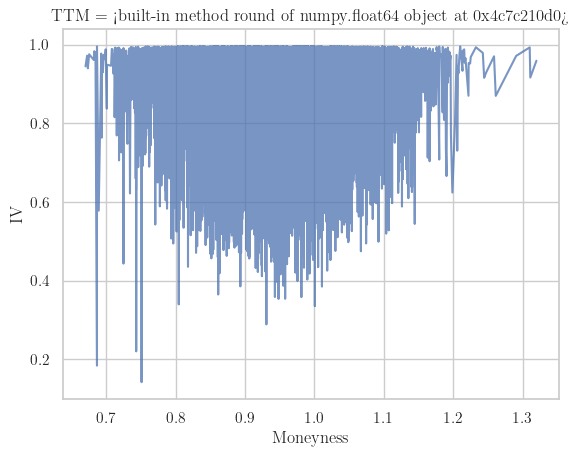

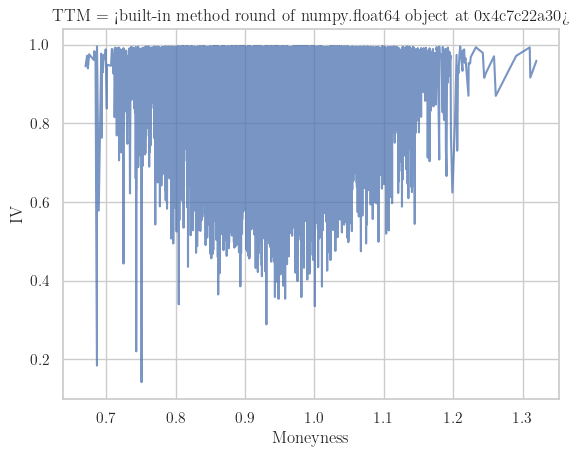

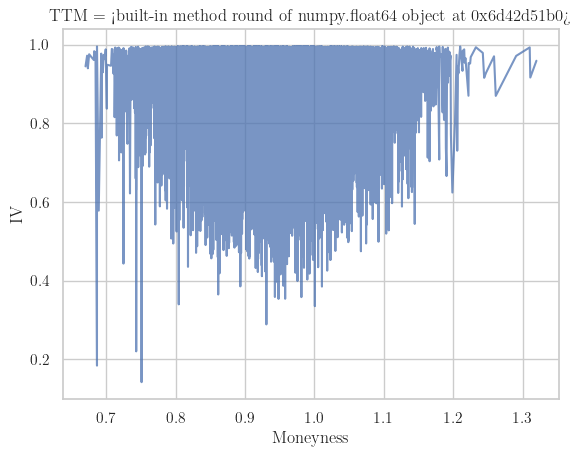

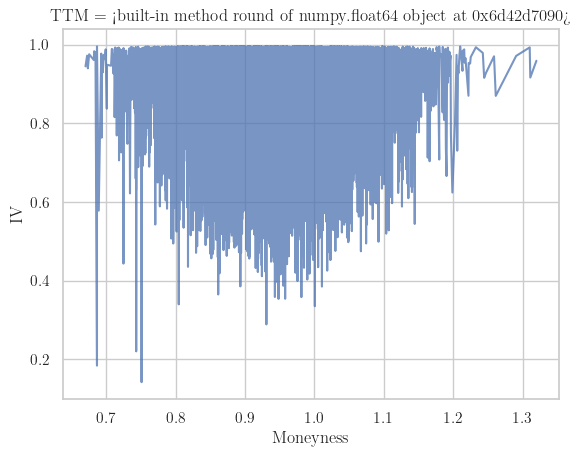

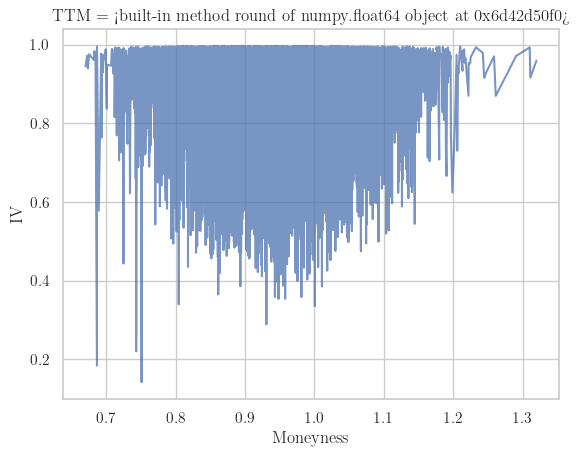

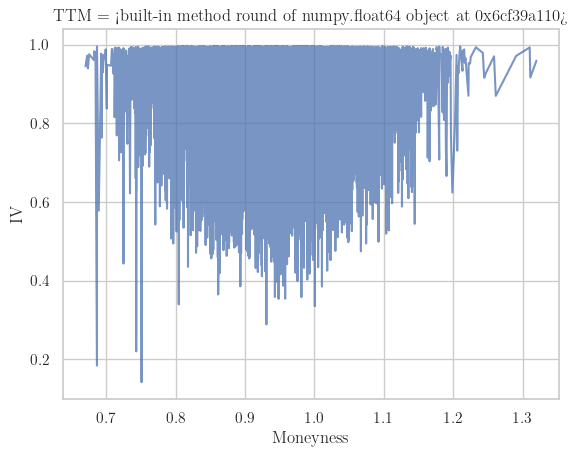

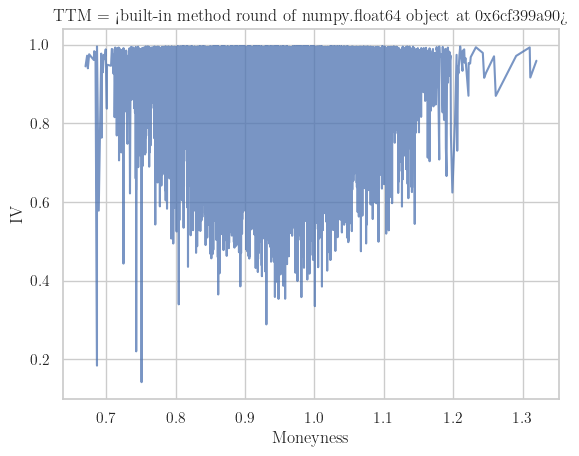

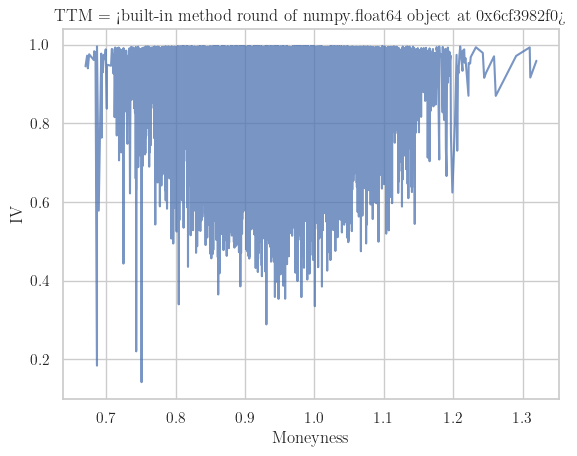

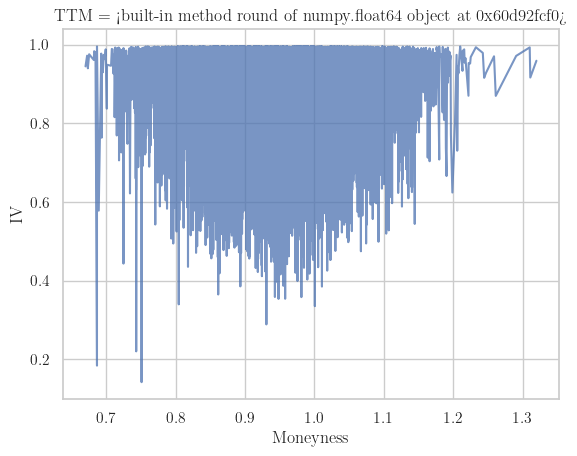

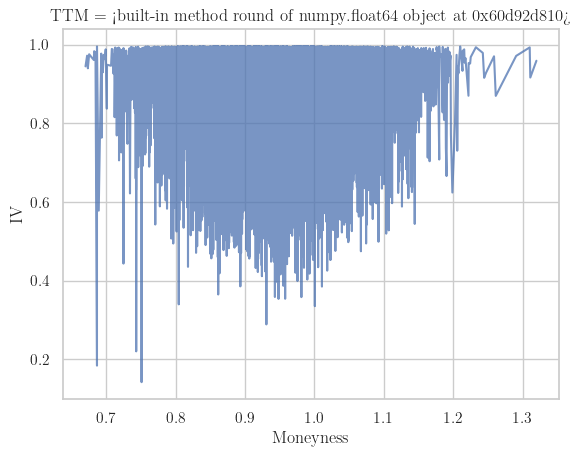

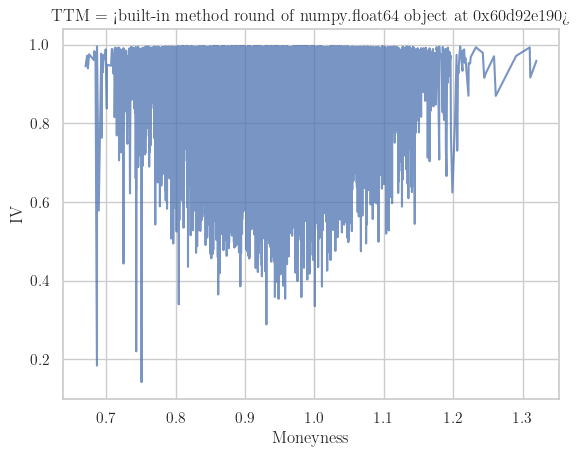

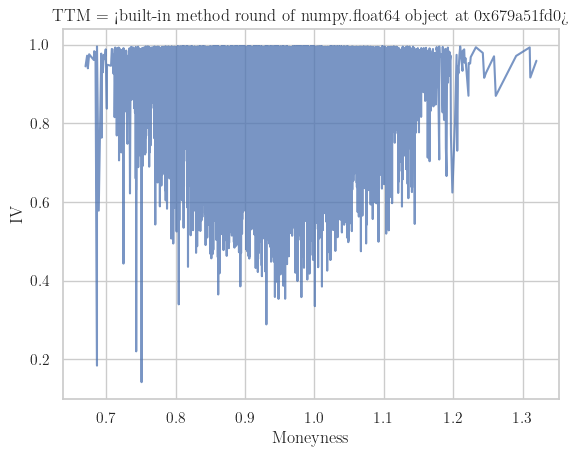

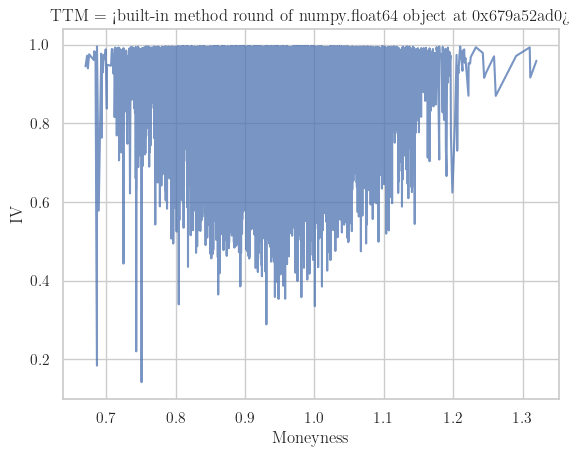

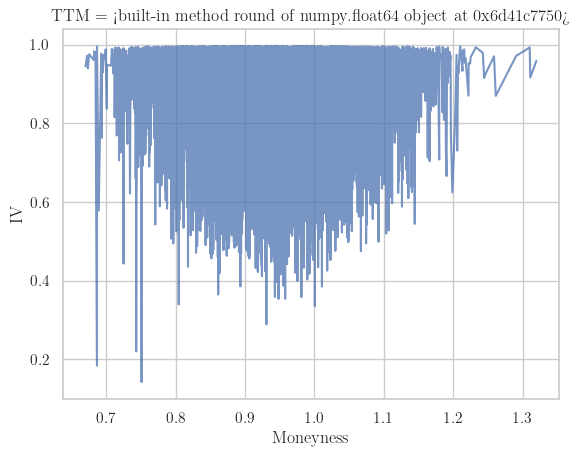

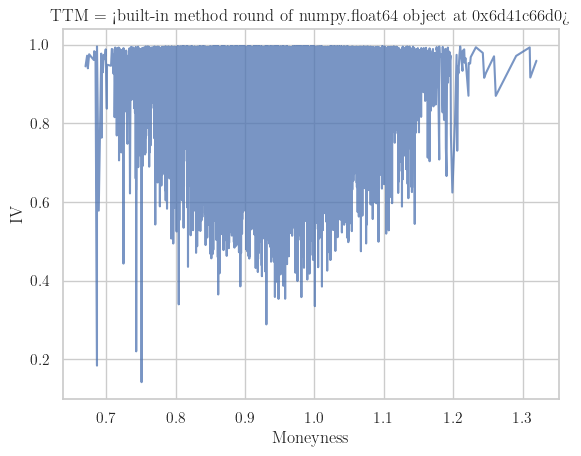

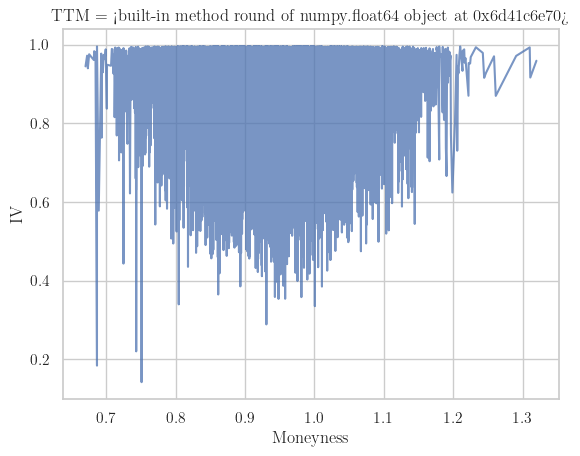

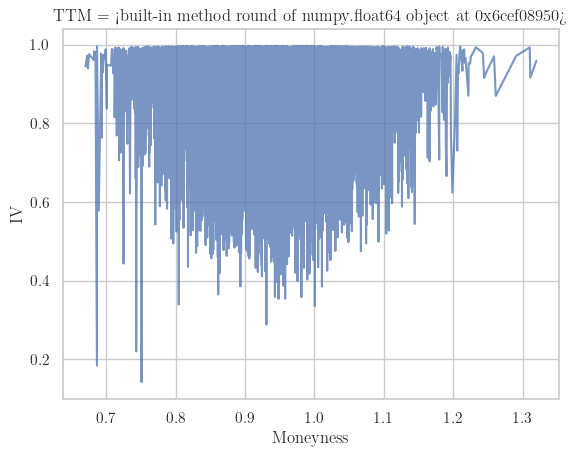

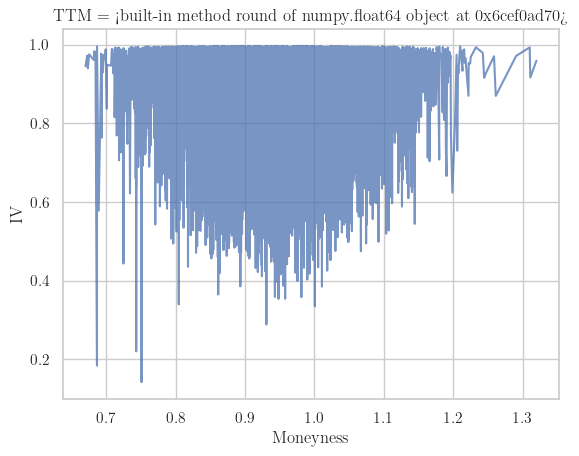

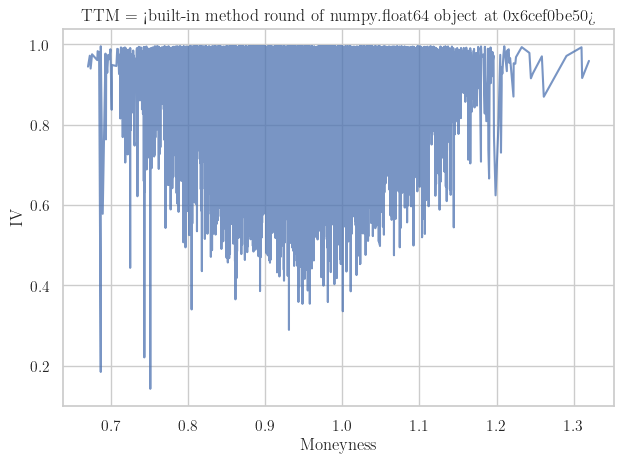

In [338]:

# Plot 'strike' against 'iv' for each 'TTM'
for ttm in unique_ttms:
    sorted_data = simulated_data_df.sort_values(by='Moneyness')
    subset = simulated_data_df[simulated_data_df['TTM'] == ttm]
    plt.figure()
    plt.plot(sorted_data['Moneyness'], sorted_data['iv'], alpha = 0.75)
    plt.title(f'TTM = {ttm.round}')
    plt.xlabel('Moneyness')
    plt.ylabel('IV')

plt.tight_layout()
plt.show()

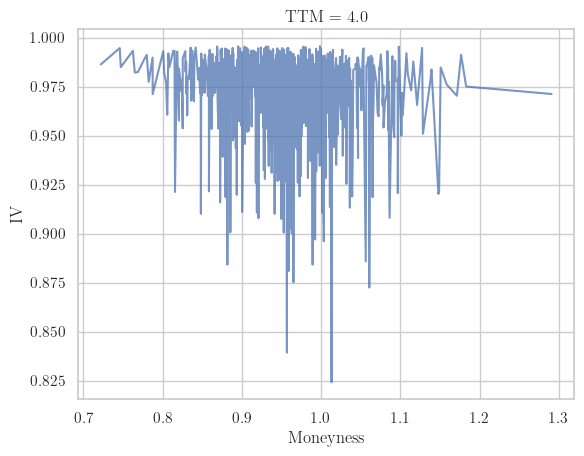

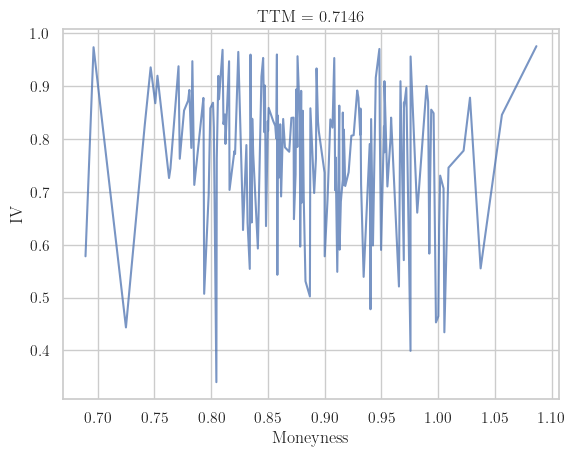

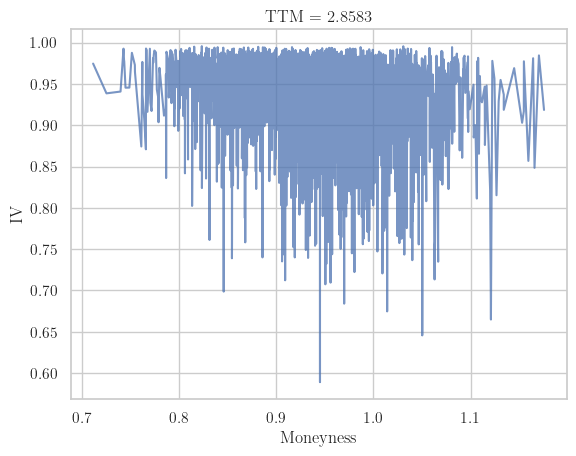

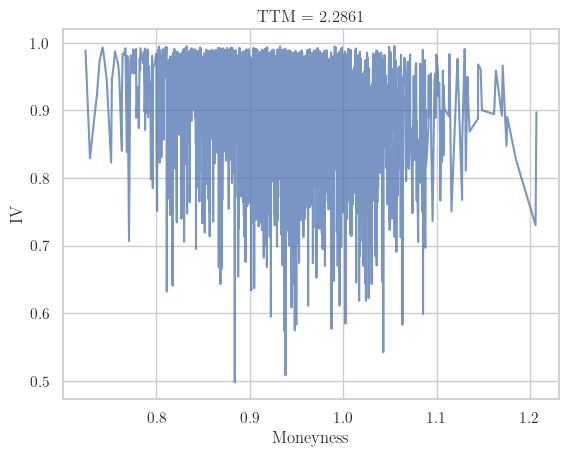

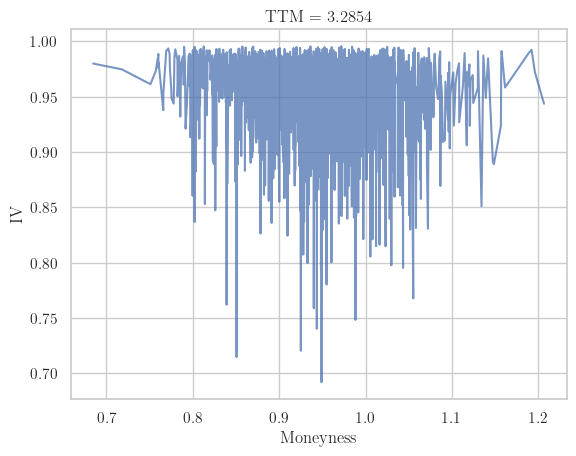

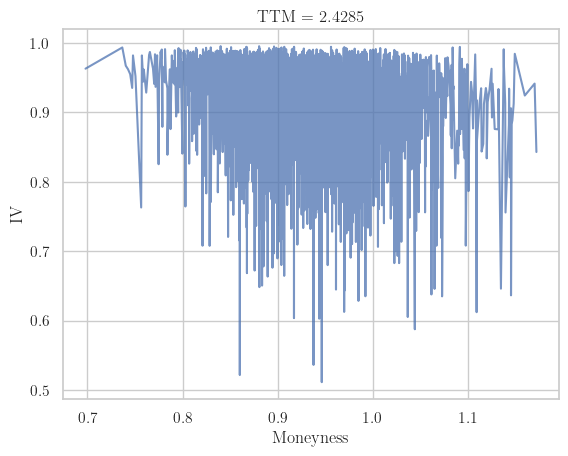

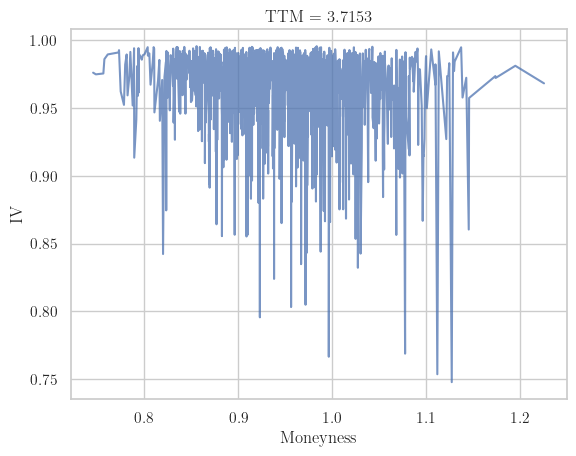

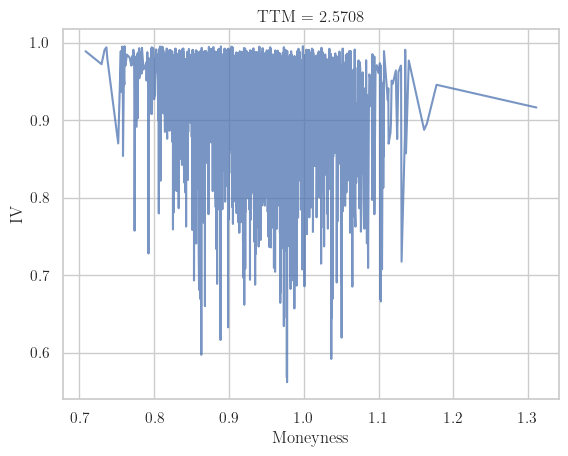

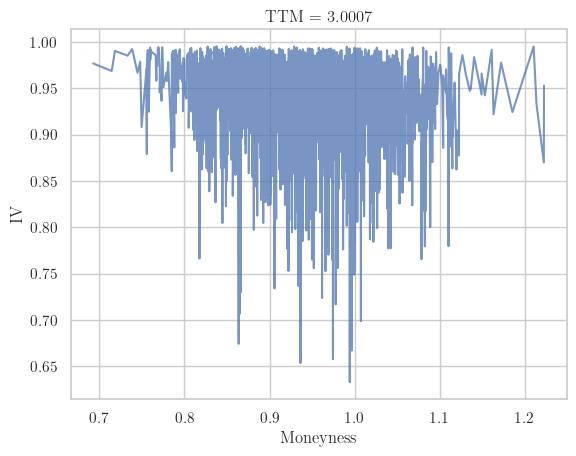

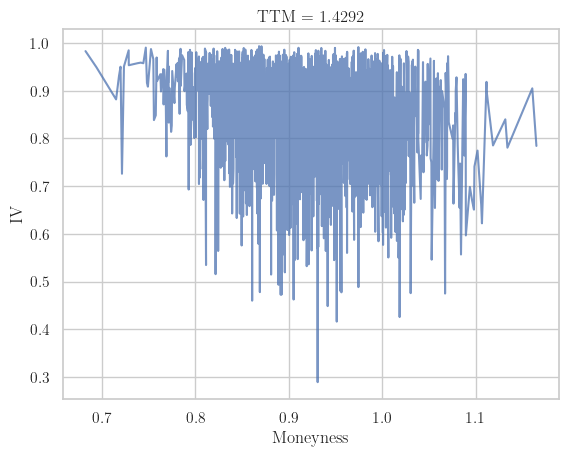

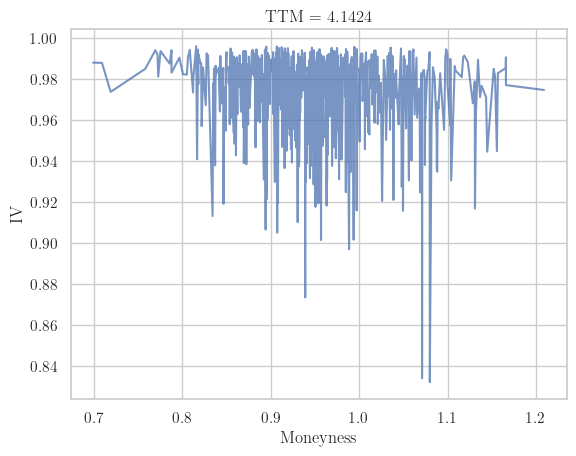

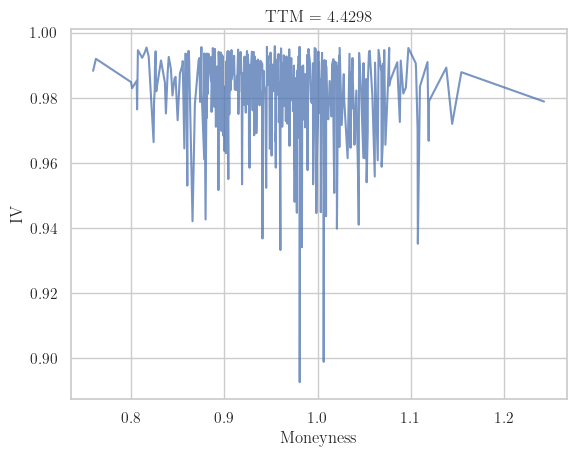

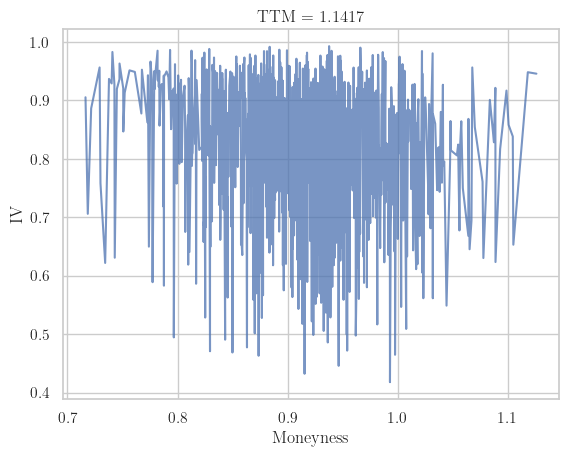

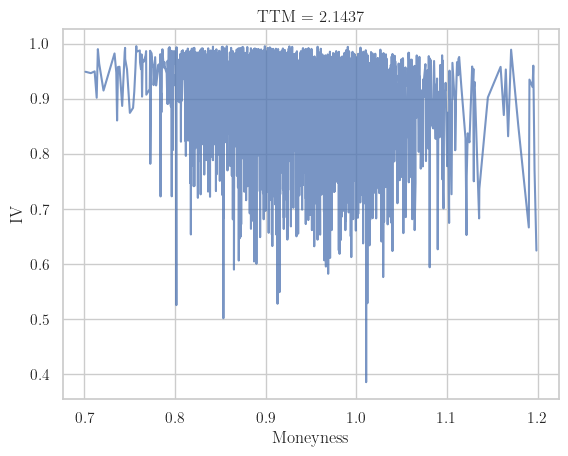

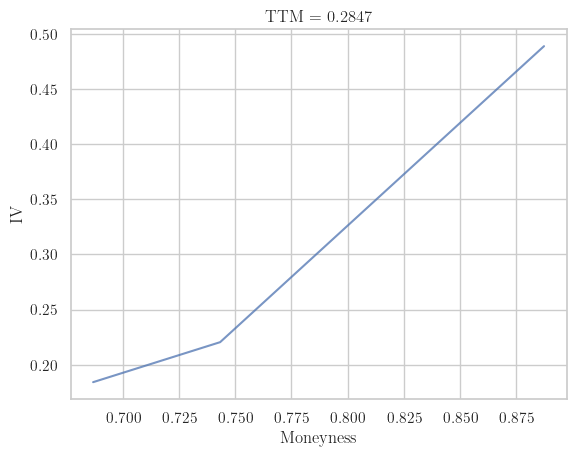

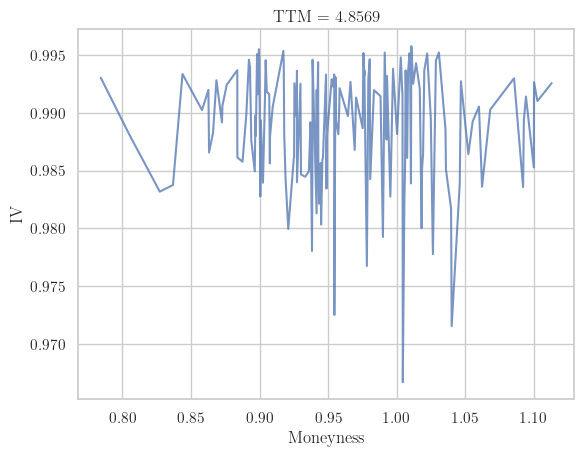

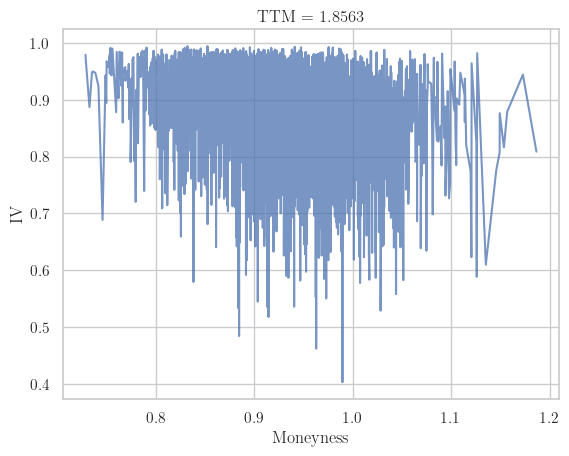

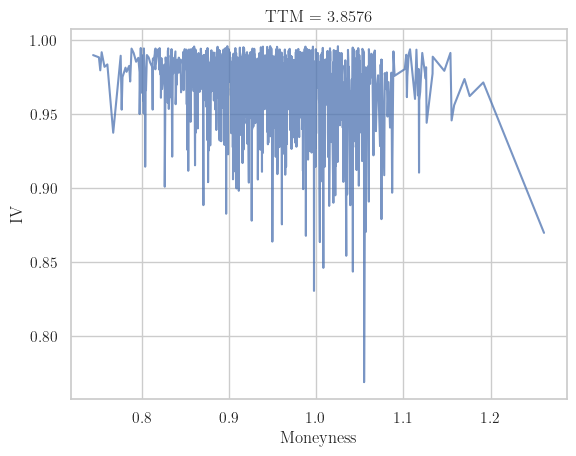

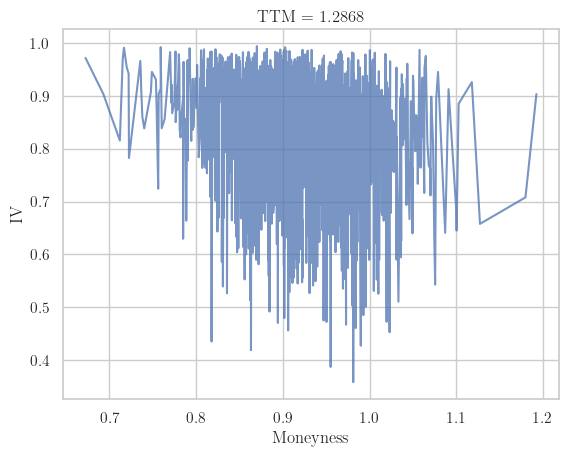

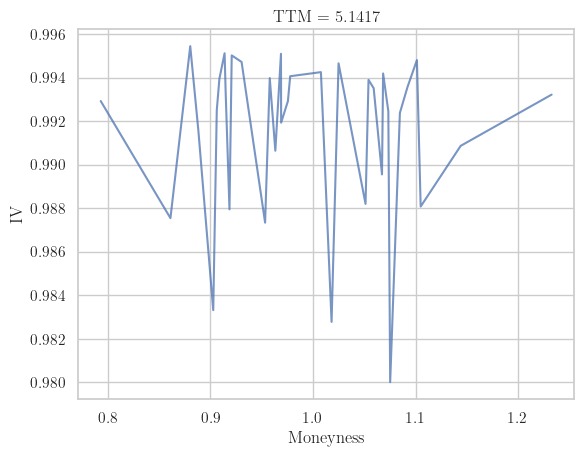

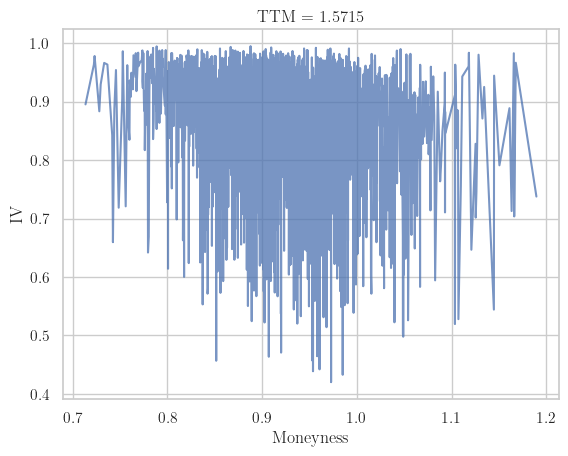

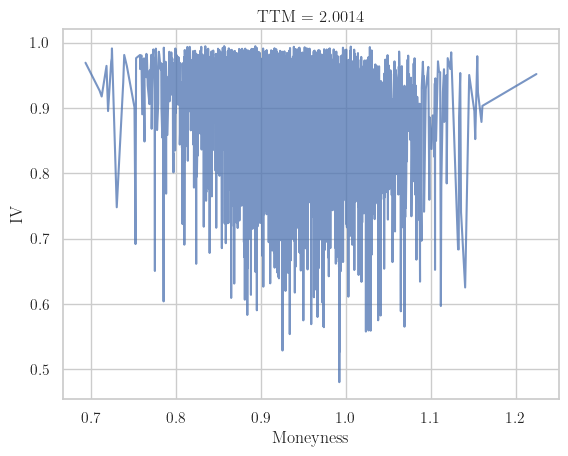

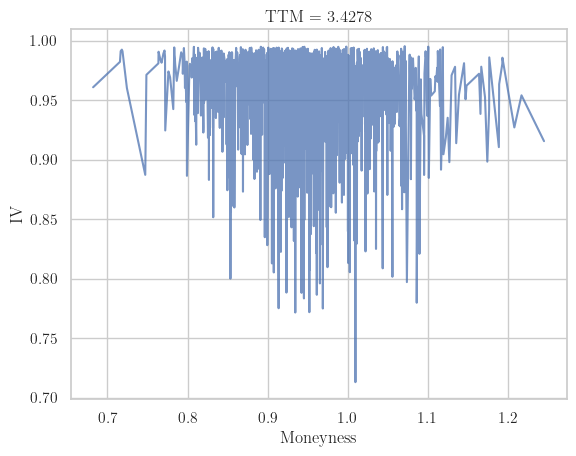

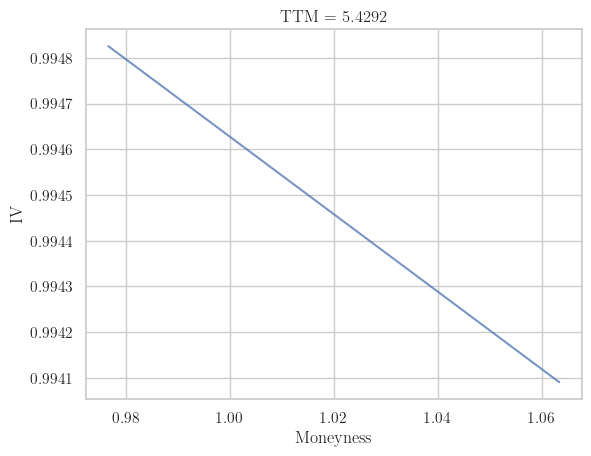

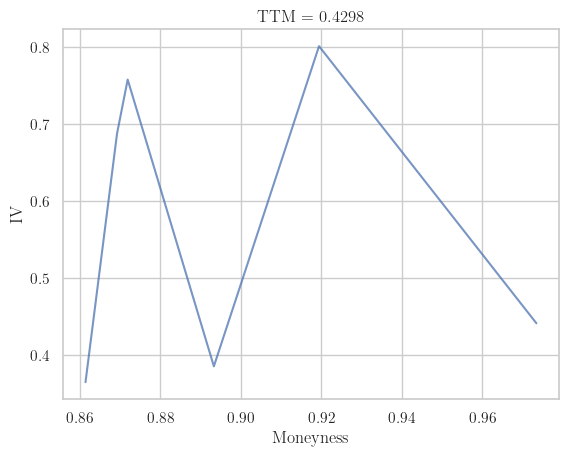

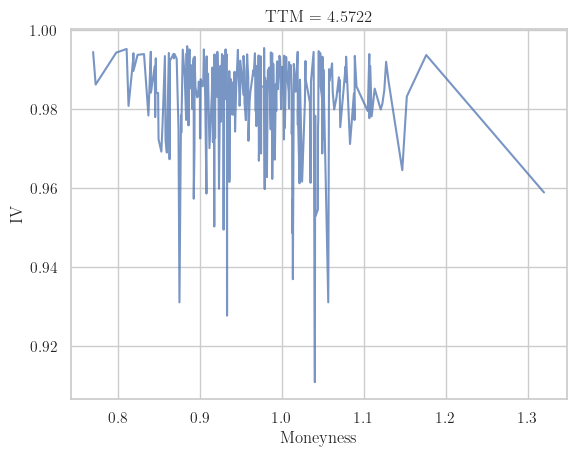

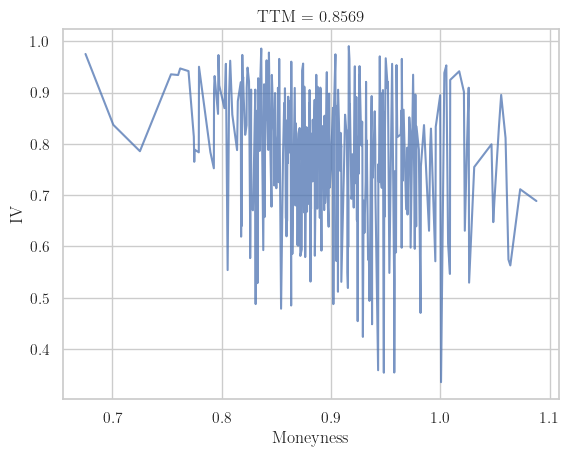

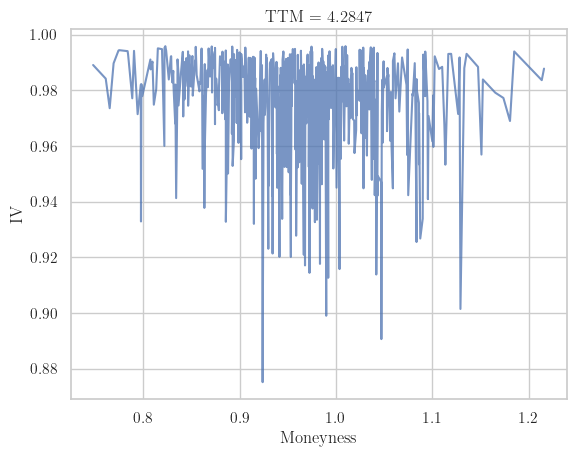

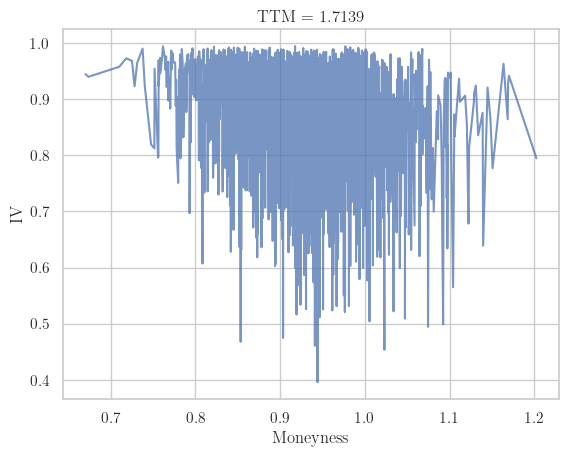

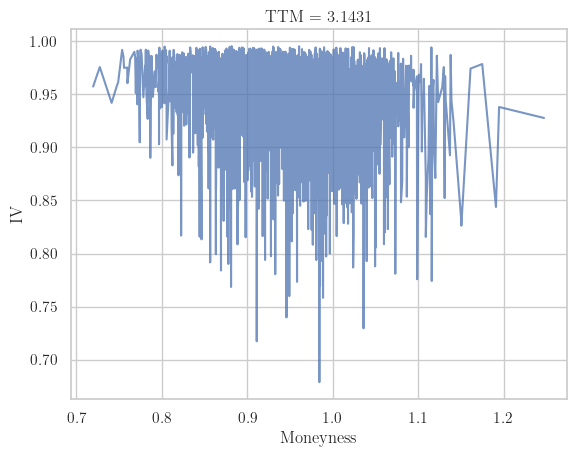

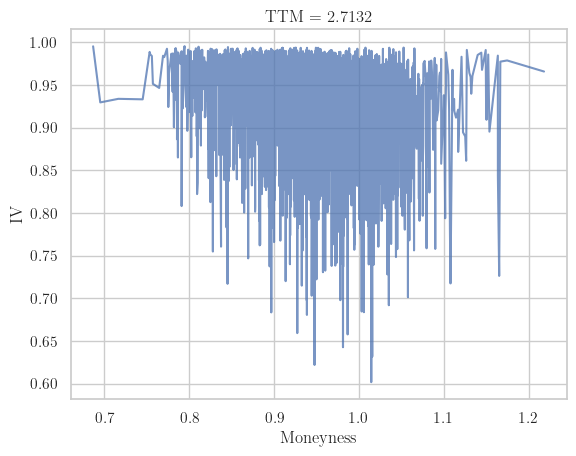

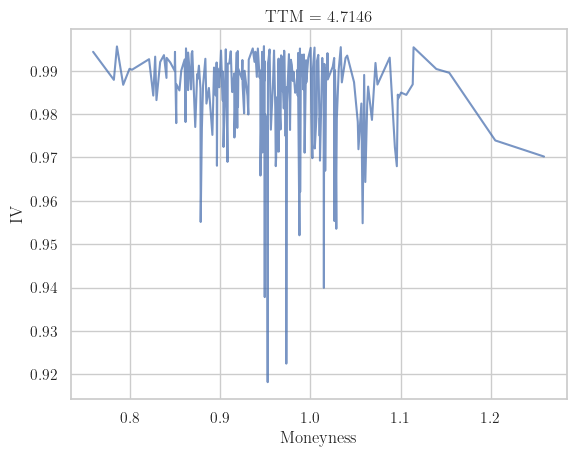

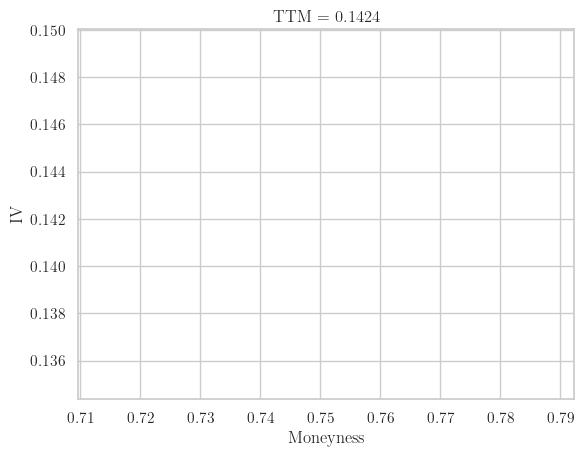

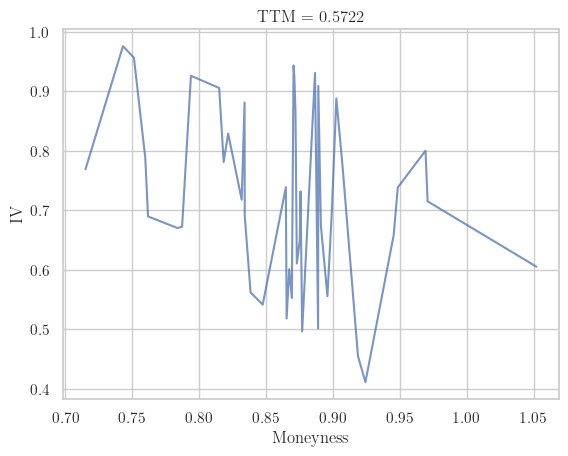

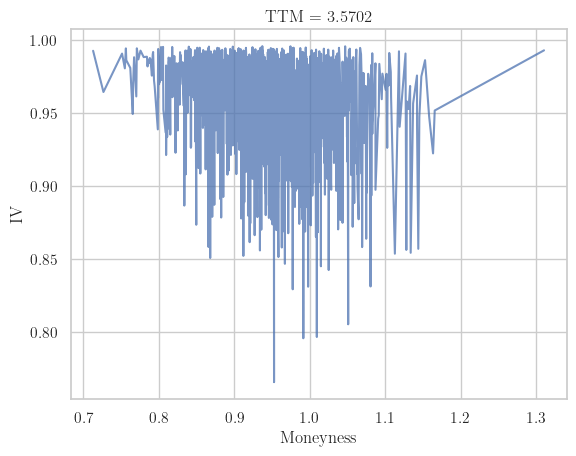

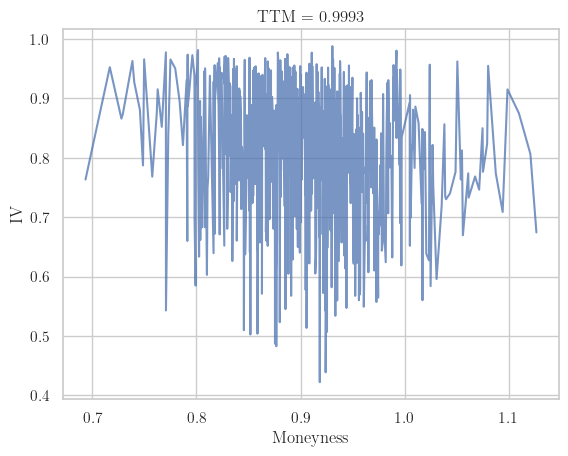

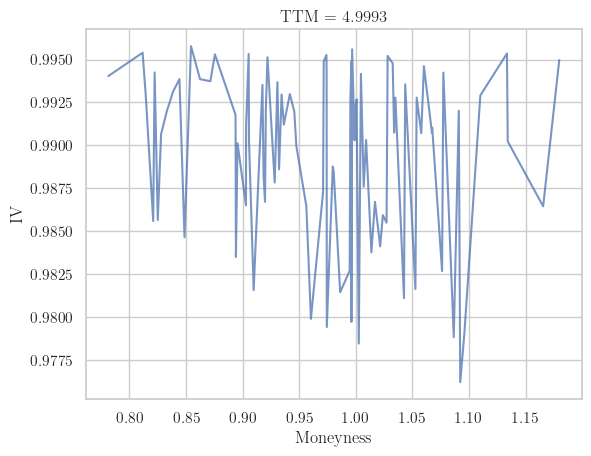

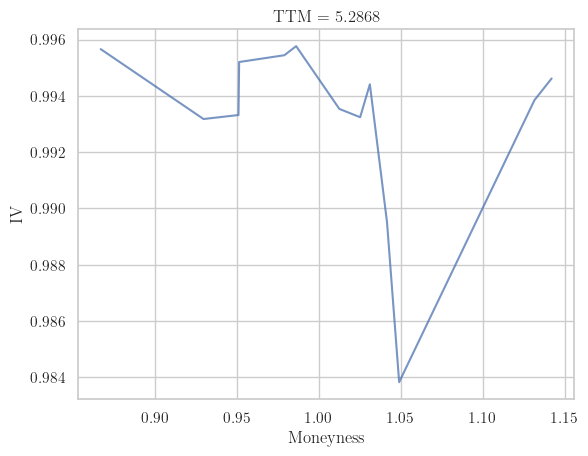

In [339]:

# Plot 'IV' against 'Moneyness' for each 'TTM'
for ttm in unique_ttms:
    # Create a subset of the data for each TTM
    subset = simulated_data_df[simulated_data_df['TTM'] == ttm]
    subset_sorted = subset.sort_values(by='Moneyness')  
    
    # Plot the data
    plt.figure()
    plt.plot(subset_sorted['Moneyness'], subset_sorted['iv'], alpha = 0.75) 
    plt.title(f'TTM = {ttm.round(4)}')
    plt.xlabel('Moneyness')
    plt.ylabel('IV')
    plt.grid(True) 
    plt.show()  

# Remove plt.tight_layout() as it is not needed when showing plots one by one

In [ ]:
simulated_data_df['futures_close'].value_counts()

futures_close
1483.500000    33
1483.500027    23
1483.500040    20
1483.500013    16
1483.500067    14
               ..
1488.029689     1
1501.640911     1
1499.339101     1
1587.342350     1
1595.202479     1
Name: count, Length: 47862, dtype: int64

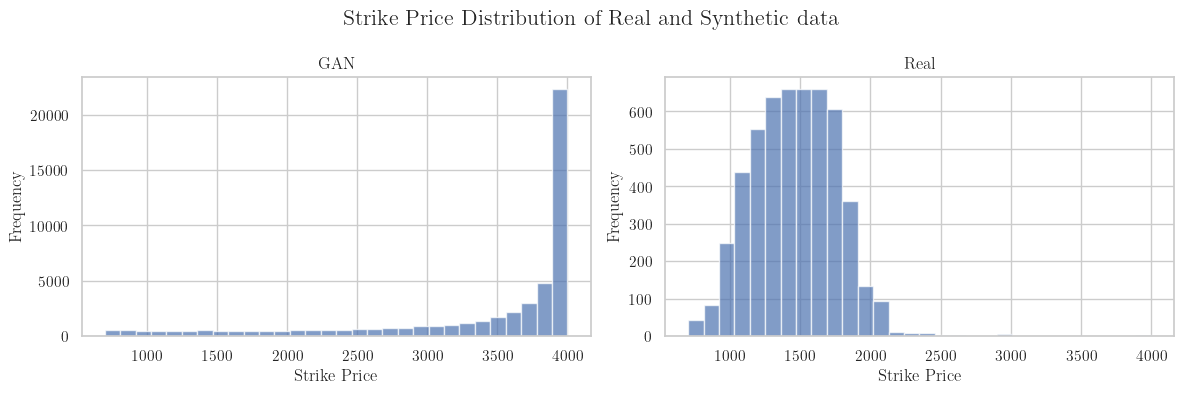

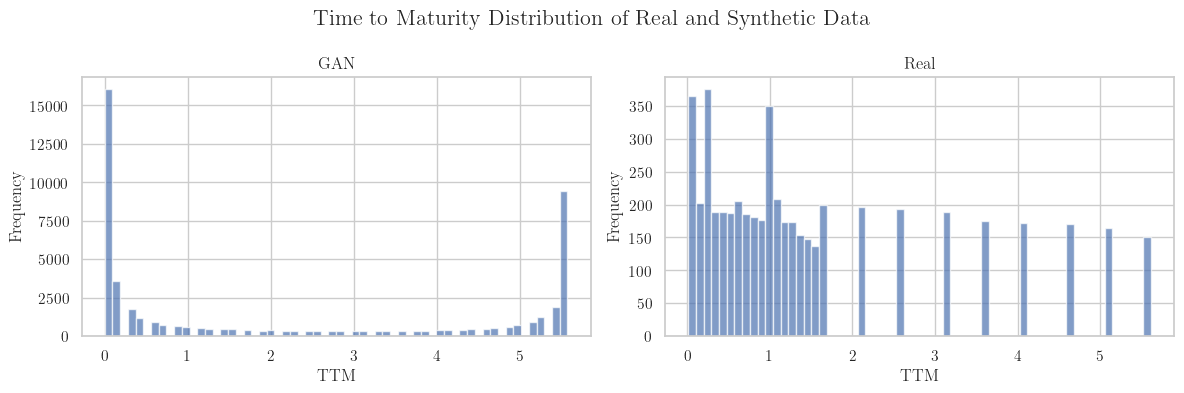

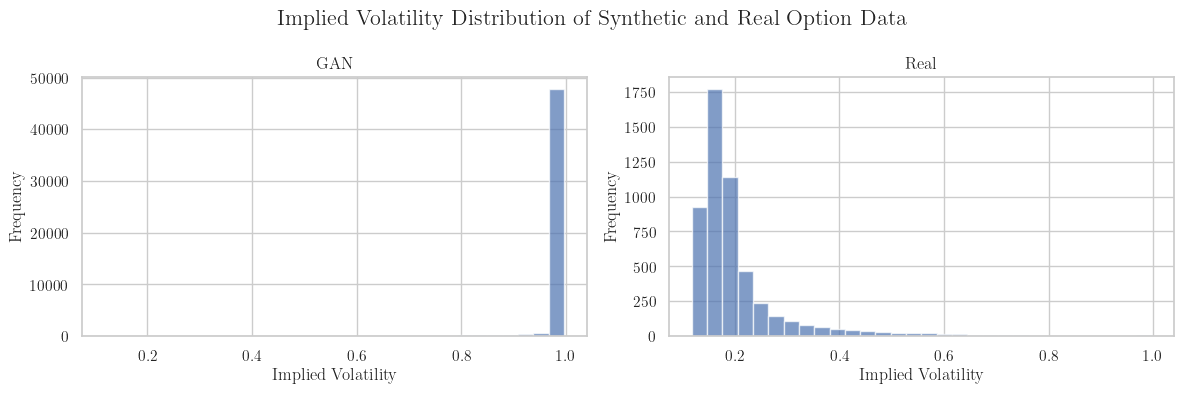

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
plt.subplot(1, 2, 1)  
plt.hist(simulated_data_df['strike'], bins=30, alpha=0.7)
plt.title('GAN')
plt.xlabel('Strike Price')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)  
plt.hist(data['strike'], bins=30, alpha=0.7)
plt.title('Real')
plt.xlabel('Strike Price')
plt.ylabel('Frequency')

fig.suptitle('Strike Price Distribution of Real and Synthetic data', fontsize=16)
plt.tight_layout()  
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
plt.subplot(1, 2, 1)  
plt.hist(simulated_data_df['TTM'], bins=60, alpha=0.7)
plt.title('GAN')
plt.xlabel('TTM')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)  
plt.hist(data['TTM'], bins=60, alpha=0.7)
plt.title('Real')
plt.xlabel('TTM')
plt.ylabel('Frequency')

fig.suptitle('Time to Maturity Distribution of Real and Synthetic Data', fontsize=16)
plt.tight_layout()  
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
plt.subplot(1, 2, 1)  
plt.hist(simulated_data_df['iv'], bins=30, alpha=0.7)
plt.title('GAN')
plt.xlabel('Implied Volatility')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)  
plt.hist(data['iv'], bins=30, alpha=0.7)
plt.title('Real')
plt.xlabel('Implied Volatility')
plt.ylabel('Frequency')

fig.suptitle('Implied Volatility Distribution of Synthetic and Real Option Data', fontsize=16)
plt.tight_layout()  
plt.show()

unique_combinations = simulated_data_df[['TTM', 'futures_close']].drop_duplicates()
kurtosis = []
skewness = []
labels = []
for index, row in unique_combinations.iterrows():
    specific_expiration_date = row['TTM']
    specific_future_close = row['futures_close']
    
    # Filter data for the specific combination
    specific_conditions = (simulated_data_df['TTM'] == specific_expiration_date) & (simulated_data_df['futures_close'] == specific_future_close)
    filtered_data = simulated_data_df[specific_conditions]
    
    sorted_data = filtered_data.sort_values(by='Moneyness')
    kurtosis_value = filtered_data['iv'].kurtosis()
    if kurtosis_value <20:
        kurtosis.append(kurtosis_value)
        labels.append(f'{specific_expiration_date} - {specific_future_close}')
        skewness.append(filtered_data['iv'].skew())
    plt.figure()
    plt.plot(sorted_data['Moneyness'], sorted_data['iv'])
    plt.title(f'Implied Volatility vs Moneyness\nExpiration Date: {specific_expiration_date}, Future Close: {specific_future_close}')
    plt.xlabel('Moneyness')
    plt.ylabel('Implied Volatility')
    plt.grid(True)

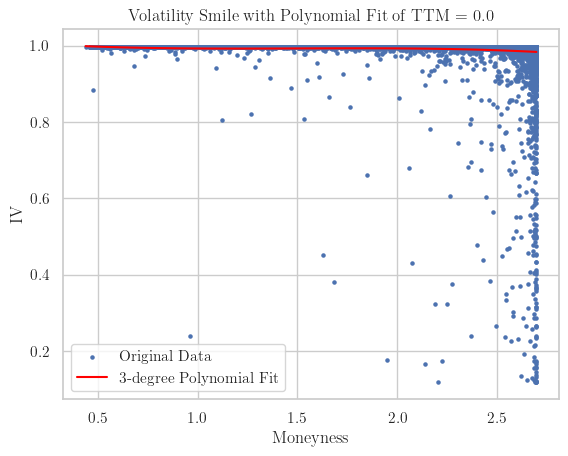

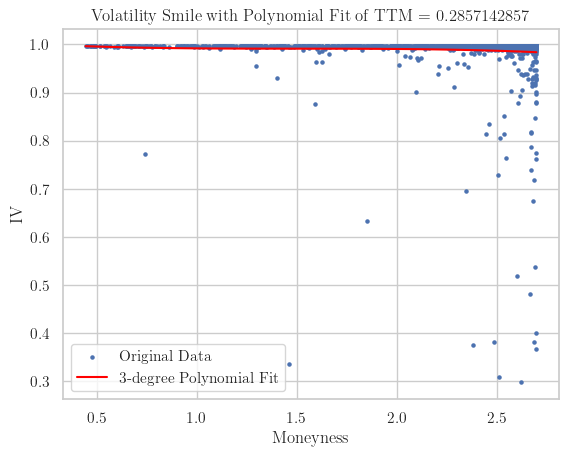

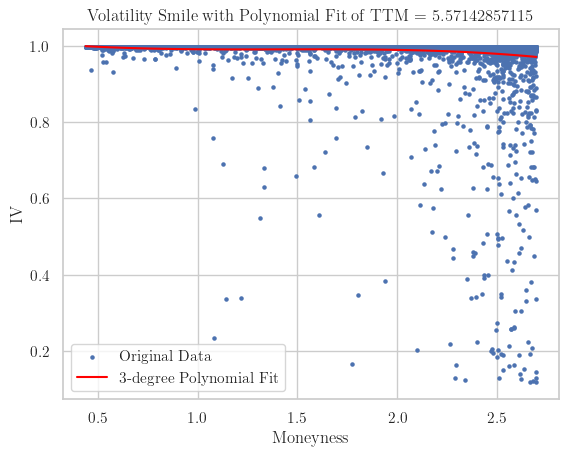

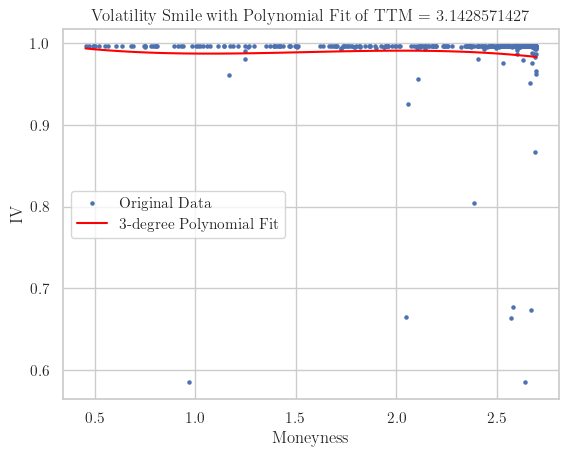

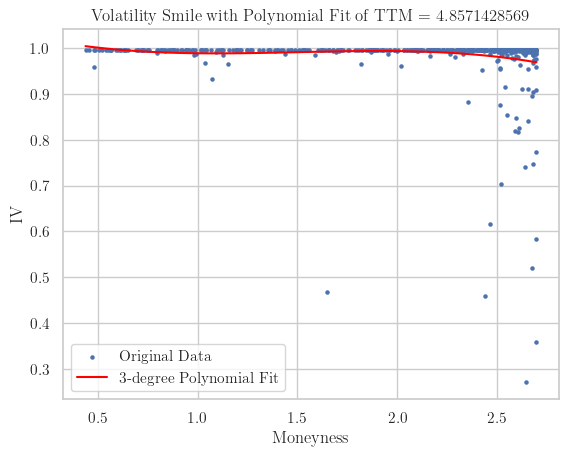

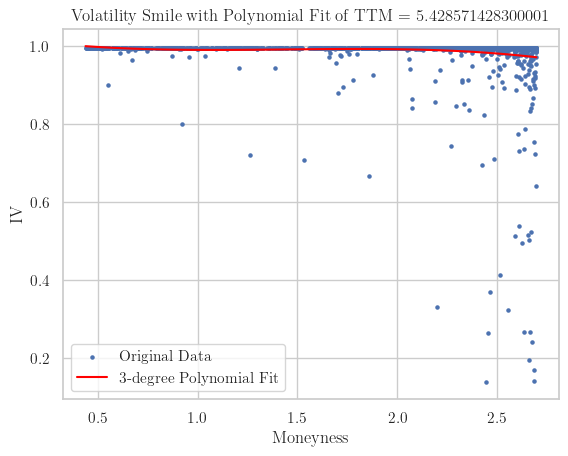

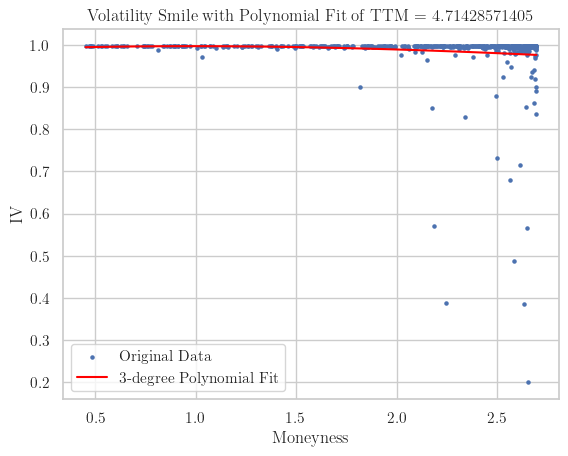

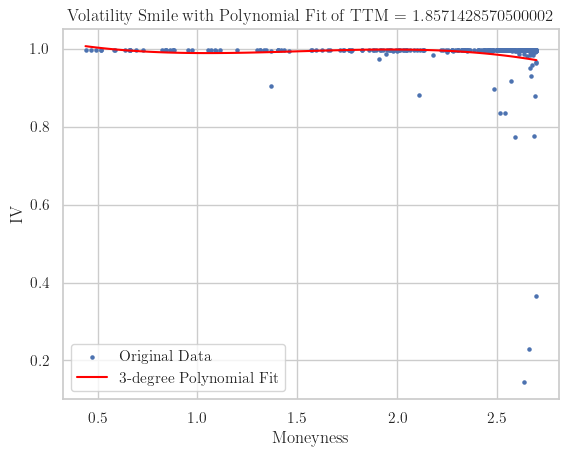

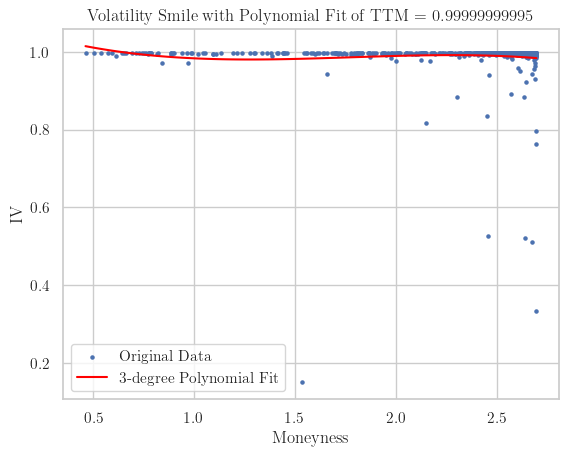

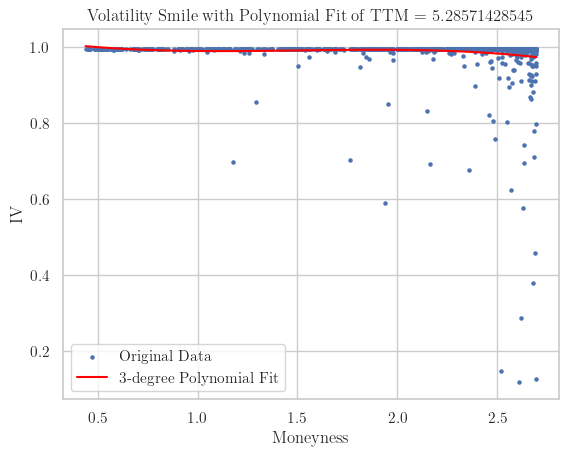

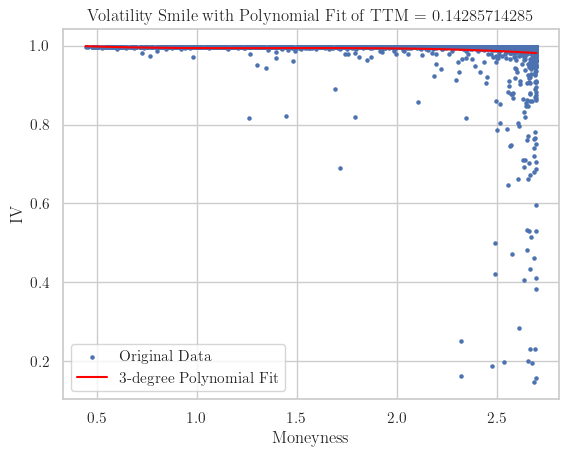

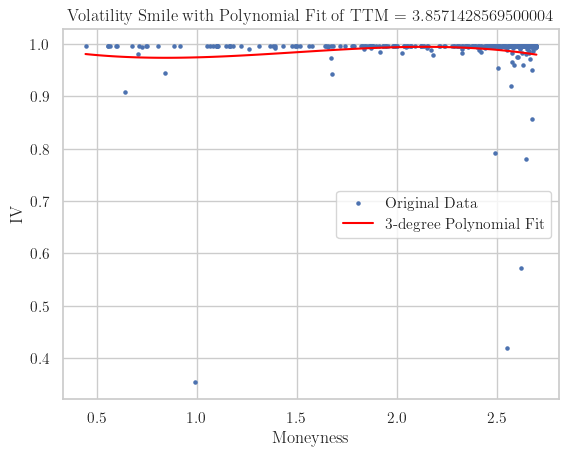

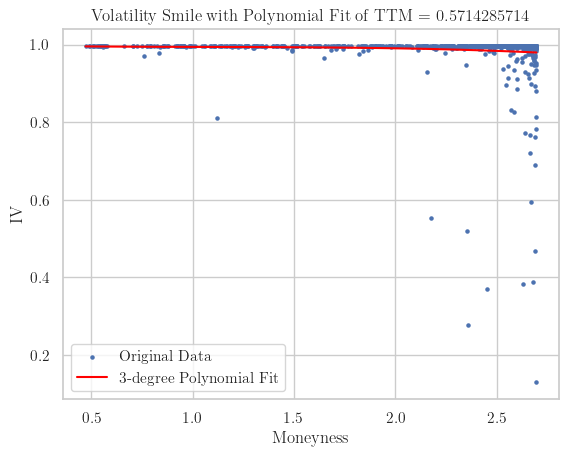

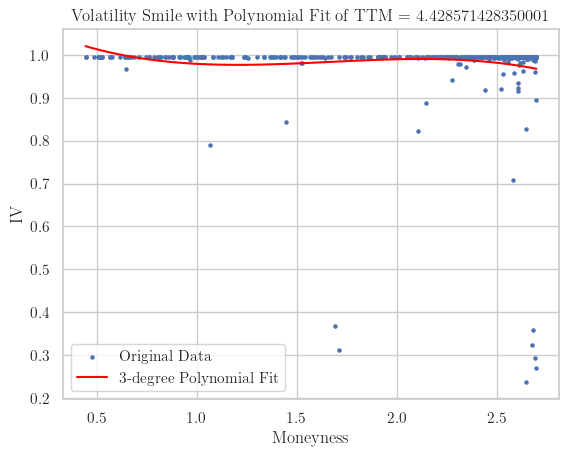

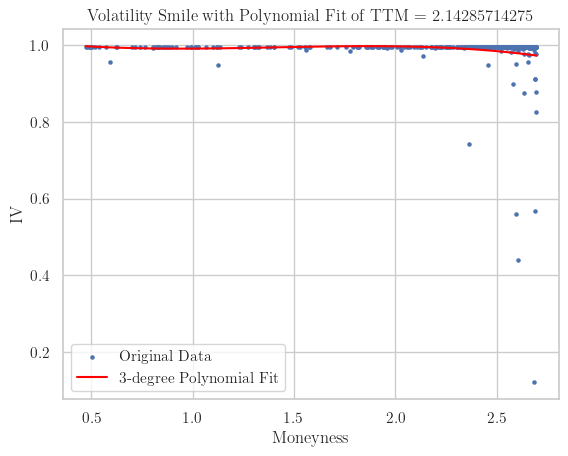

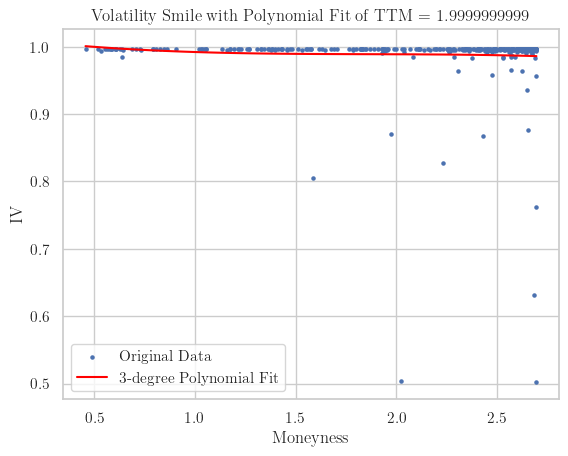

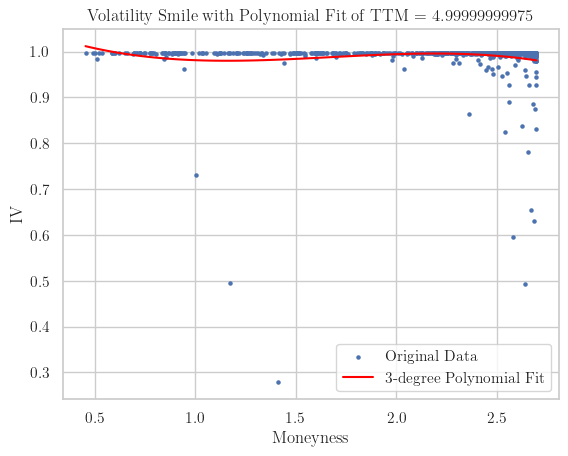

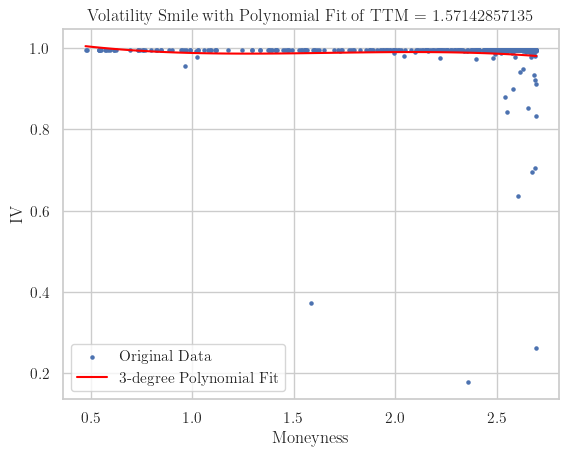

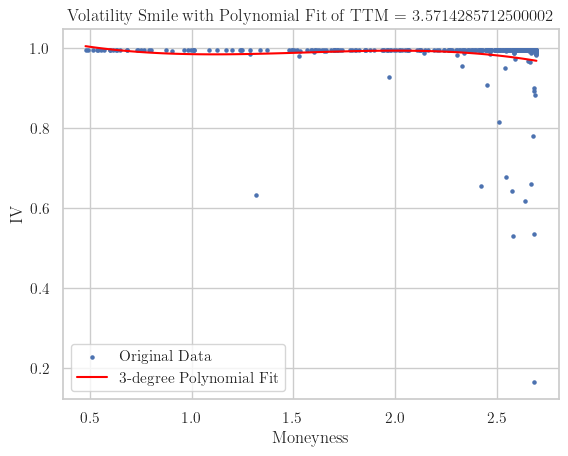

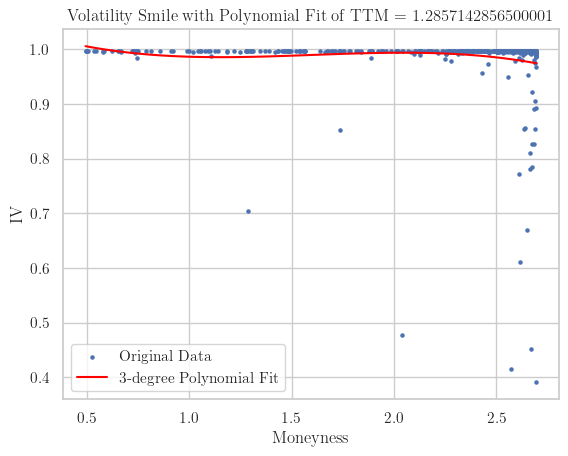

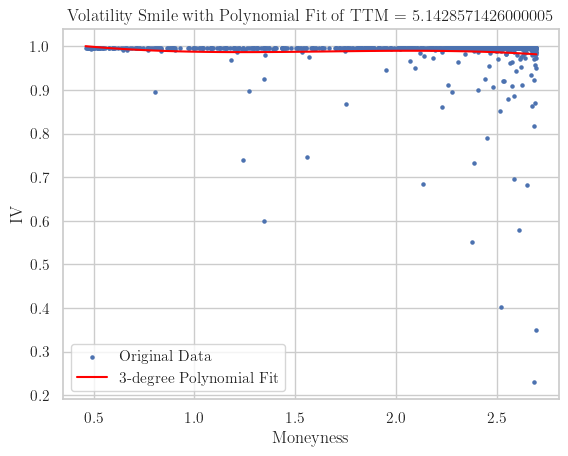

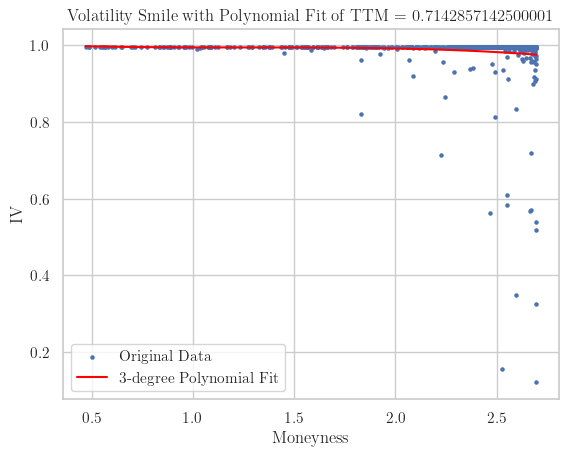

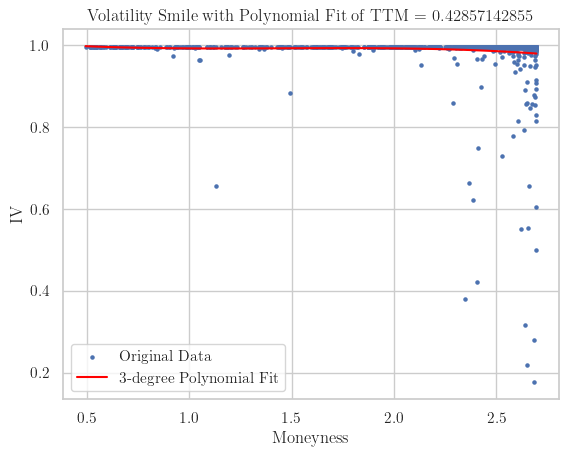

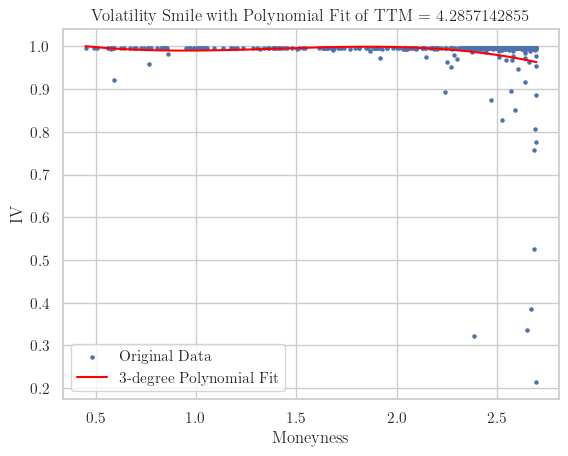

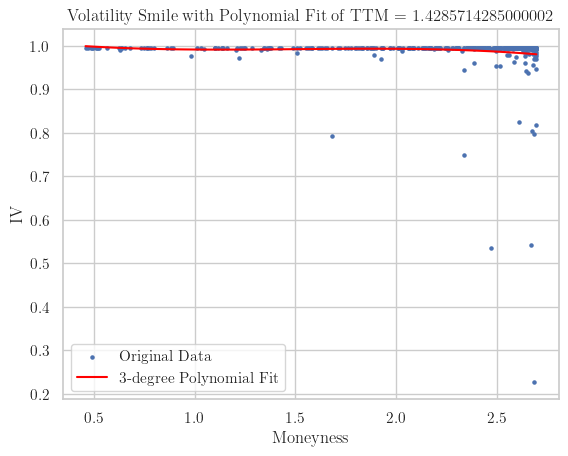

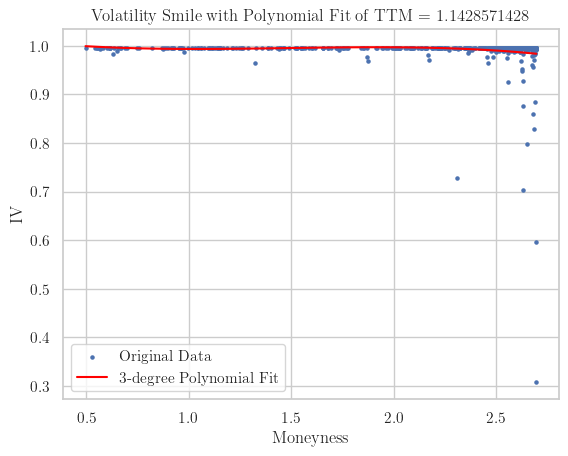

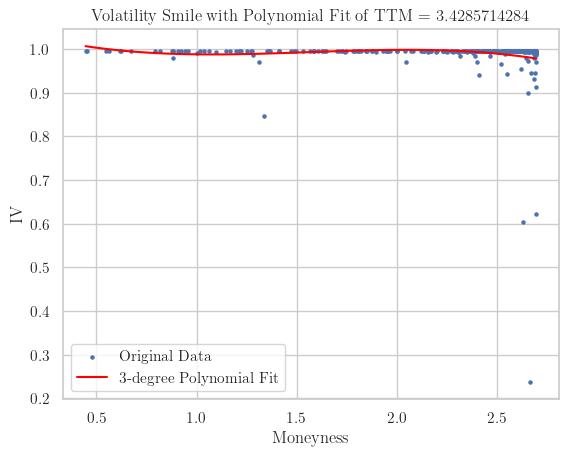

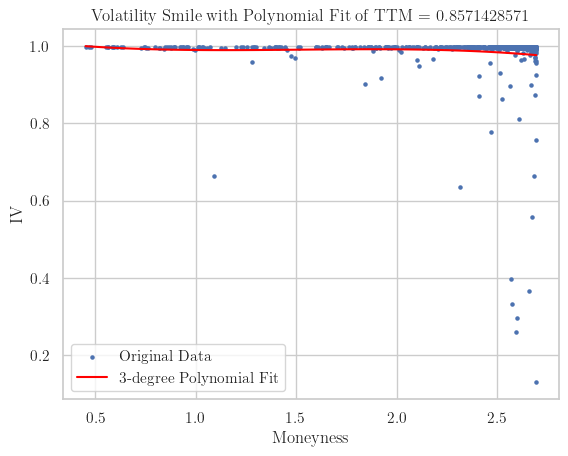

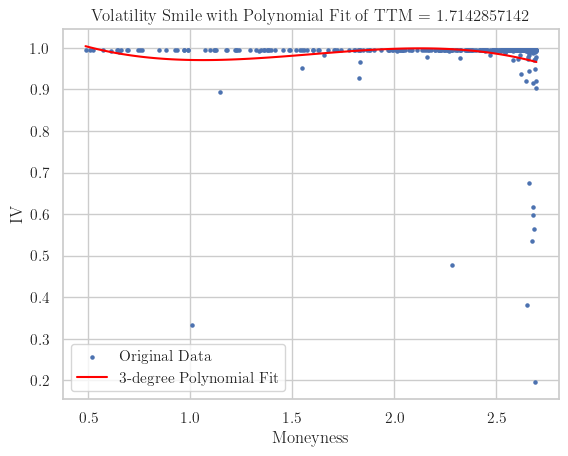

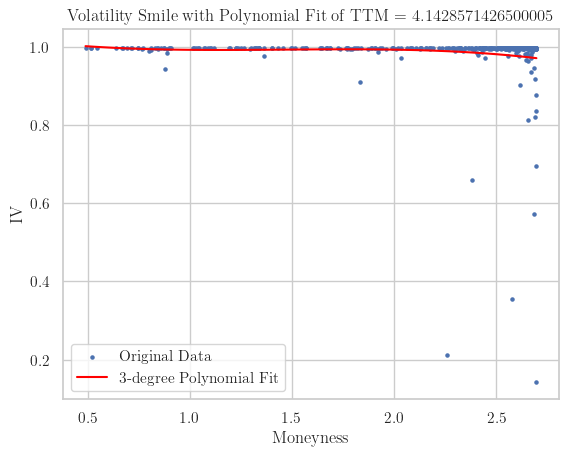

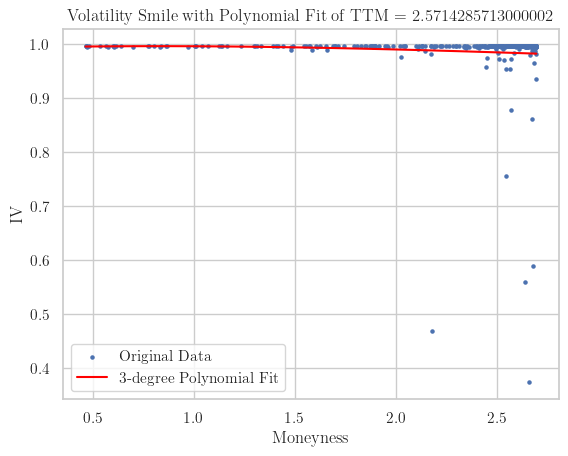

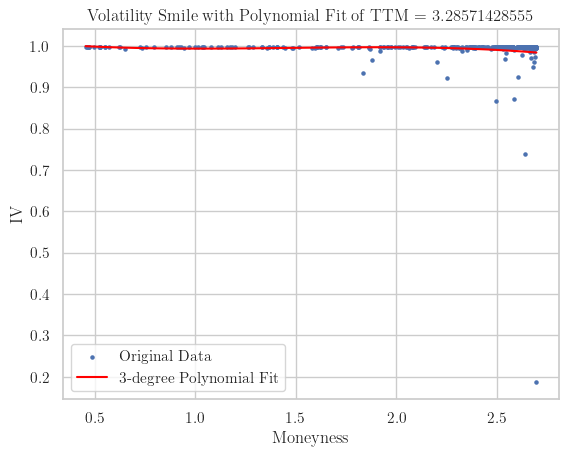

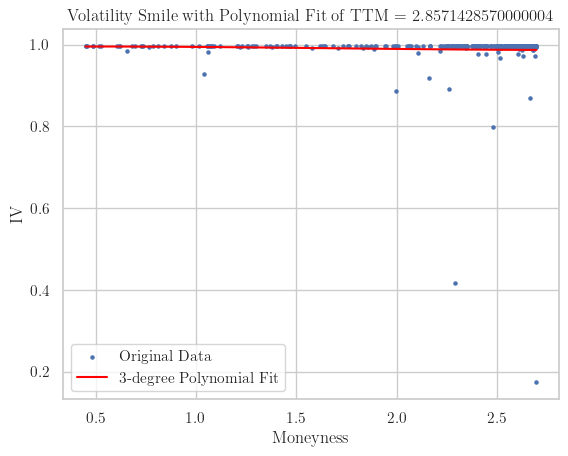

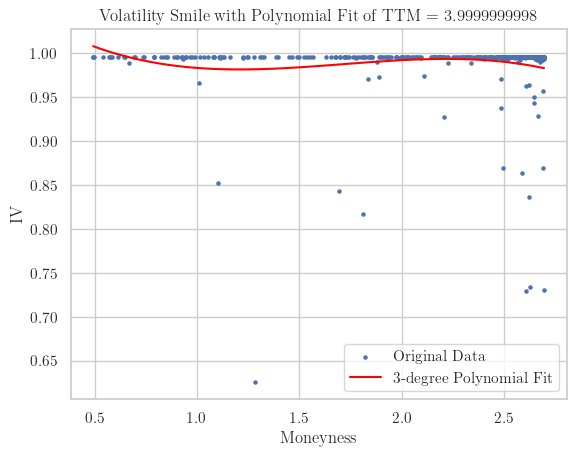

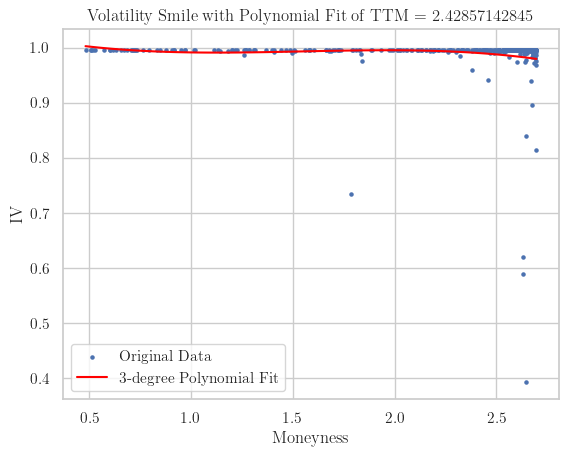

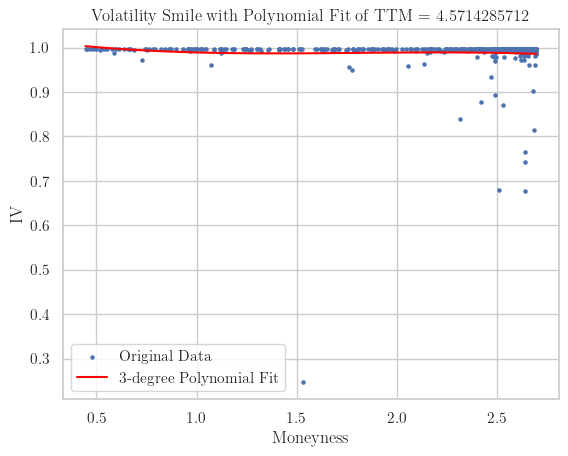

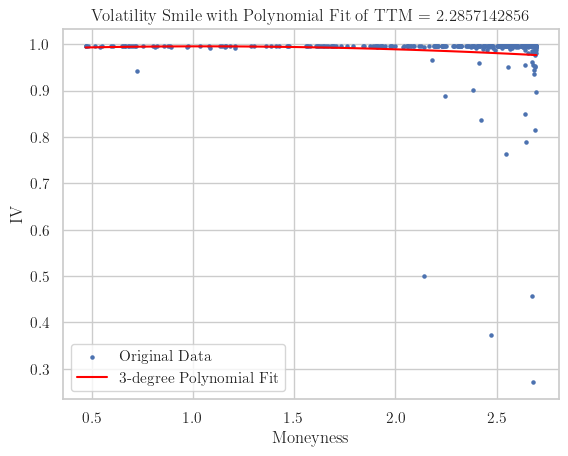

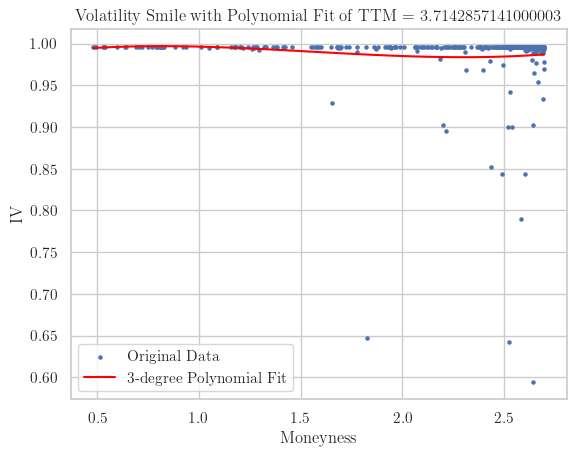

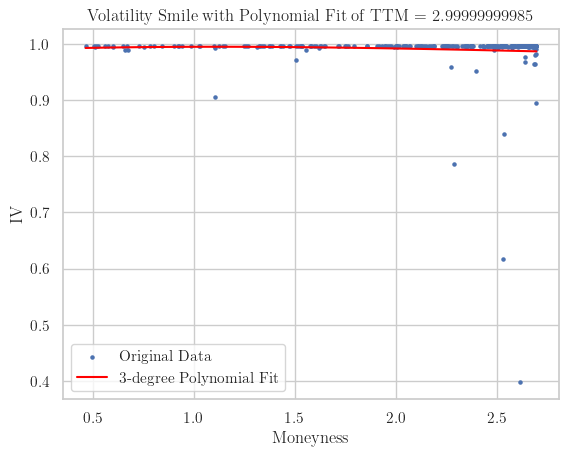

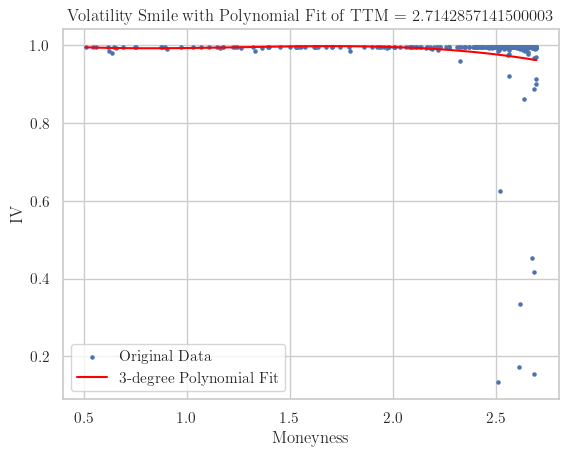

In [ ]:
# Fit a polynomial of degree n (e.g., n=3 for cubic)
n = 3

for ttm in unique_ttms:
    subset = simulated_data_df[simulated_data_df['TTM'] == ttm]
    subset_sorted = subset.sort_values(by='Moneyness')  
    coefficients = np.polyfit(subset_sorted['Moneyness'], subset_sorted['iv'], n)

    # Create a polynomial function with the obtained coefficients
    polynomial = np.poly1d(coefficients)

    # Generate x values for plotting the polynomial curve
    x_values = np.linspace(subset_sorted['Moneyness'].min(), subset_sorted['Moneyness'].max(), 100)

    # Plot the original data and the fitted polynomial curve
    plt.figure()
    plt.scatter(subset_sorted['Moneyness'], subset_sorted['iv'], label='Original Data', s = 5)
    plt.plot(x_values, polynomial(x_values), color='red', label=f'{n}-degree Polynomial Fit')
    plt.title(f'Volatility Smile with Polynomial Fit of TTM = {ttm}')
    plt.xlabel('Moneyness')
    plt.ylabel('IV')
    plt.legend()
    plt.show()